In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sk
import nltk
from nltk.corpus import wordnet
from collections import Counter


#nltk.download('wordnet')
#nltk.download('punkt')
#nltk.download('averaged_perceptron_tagger')
#nltk.download('stopwords')

from nltk import word_tokenize, pos_tag
from nltk.corpus import stopwords
import pandas as pd
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
import nltk

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt


from sklearn.svm import SVC
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
import pandas as pd
import matplotlib.patches as mpatches
from matplotlib.colors import ListedColormap


#%matplotlib qt
%matplotlib inline

# Prétraitement
-
-
-
-

In [2]:
df = pd.read_csv("scitweets_export.tsv", sep = "\t")

In [3]:
# Téléchargement des ressources NLTK
#nltk.download('stopwords')
#nltk.download('punkt')
#nltk.download('wordnet')

# Chargement des données
file_path = 'scitweets_export.tsv'
df = pd.read_csv(file_path, sep='\t')

# Prétraitement du texte (identique à votre version)
stop_words = set(stopwords.words('english'))
custom_stop_words = {"http", "https", "rt", "co", "amp", "via"}
#negations = {"not", "no", "nor", "neither", "never", "none"}
stop_words.update(custom_stop_words)
lemmatizer = WordNetLemmatizer()

def preprocess_tweet(tweet):
    tweet = re.sub(r"@\w+|\W", " ", tweet)
    tweet = tweet.lower()
    tokens = word_tokenize(tweet)
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return " ".join(tokens)

df['cleaned_text'] = df['text'].apply(preprocess_tweet)

In [4]:
cleaned_text = []
for sentence in df["cleaned_text"]:
    cleaned_text.append(sentence.split(" "))

In [5]:
full_text = []
for sentence in df["text"]:
    full_text.append(sentence.split(" "))

In [6]:
def plot_word_distribution(word_list, nombre_de_mots):
    word_list_flat = [word for sublist in word_list for word in sublist]
    word_counts = Counter(word_list_flat)
    # 3. Afficher les 10 mots les plus fréquents (optionnel)
    most_common = word_counts.most_common(nombre_de_mots)
    #print(most_common[0:10])
    words, counts = zip(*most_common)
    
    # 4. Tracer avec seaborn
    #plt.figure(figsize=(30, 12))
    plt.figure(figsize=(16, 8)).gca()
    sns.barplot(x=list(words), y=list(counts))
    plt.title("Distribution des " + str(nombre_de_mots) + " mots les plus fréquents", fontsize = 25)
    plt.ylabel("Nombre d'occurrences", fontsize = 20)
    plt.xlabel("Mots", fontsize = 20)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


## Distribution des mots avant prétraitement

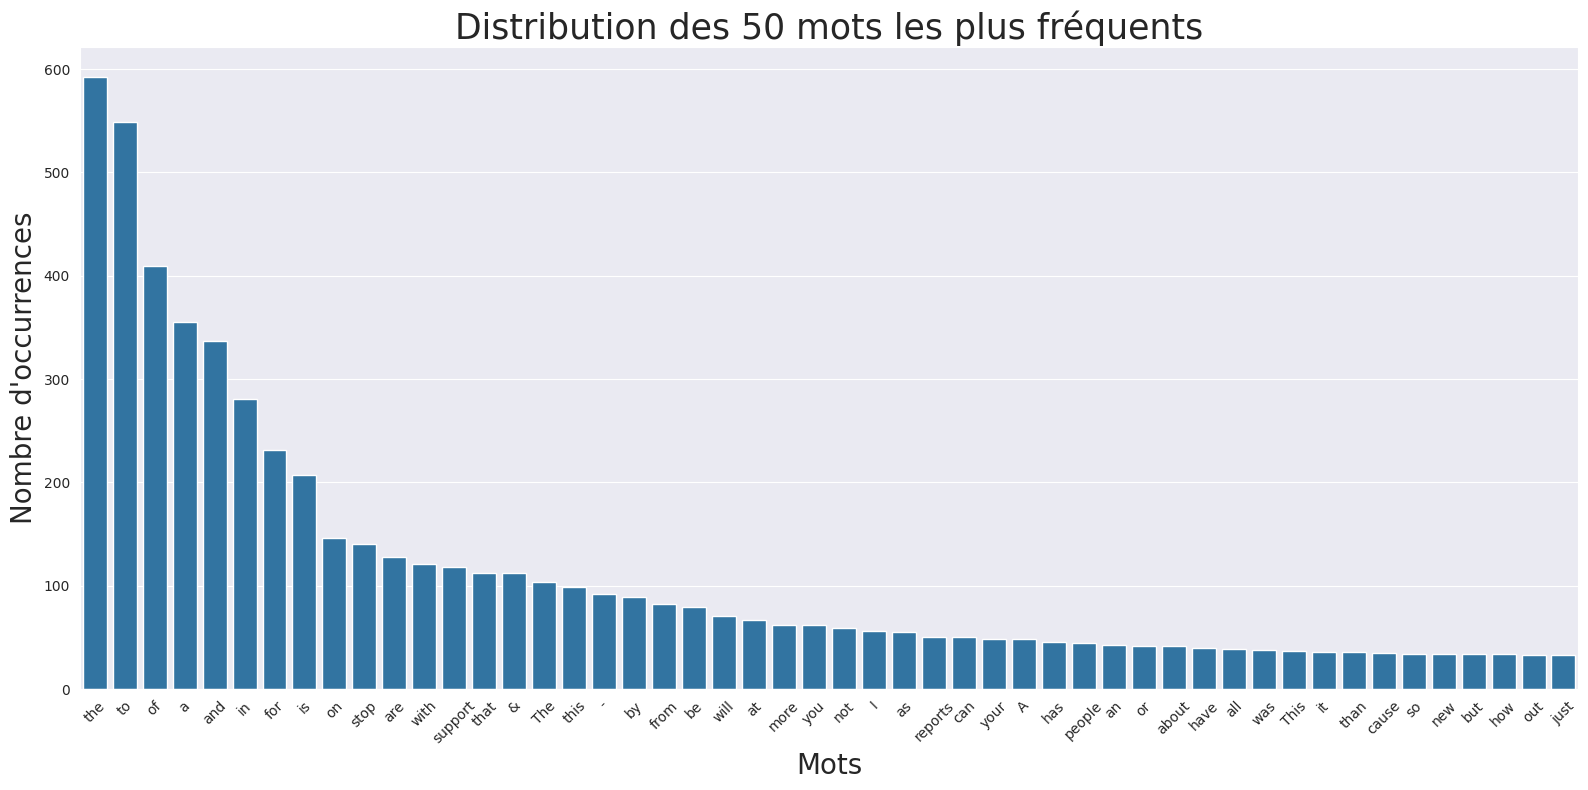

In [7]:
plot_word_distribution(full_text, nombre_de_mots=50)

## Distribution des mots après prétraitement

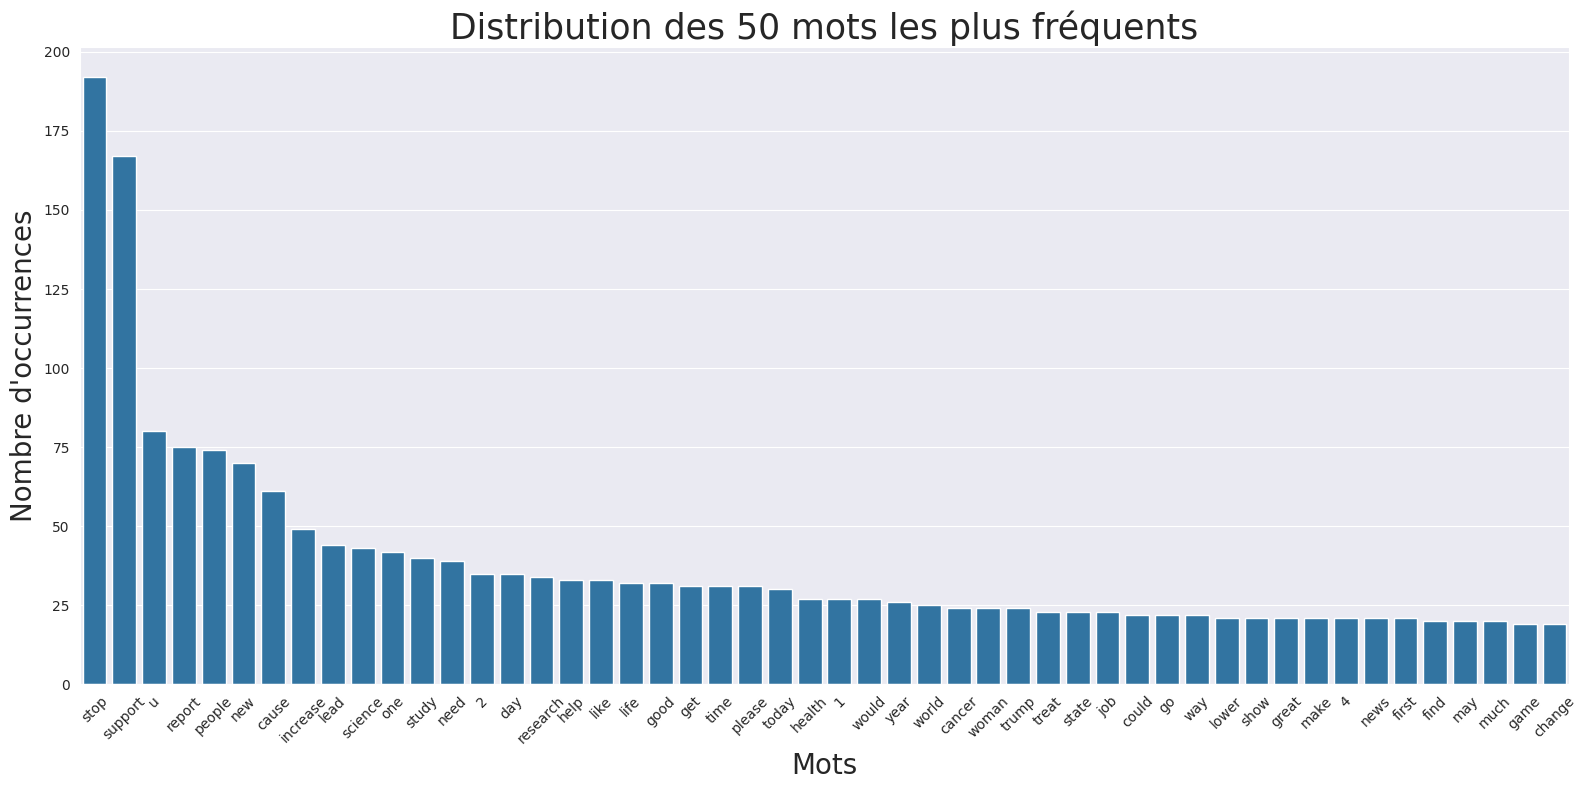

In [8]:
plot_word_distribution(cleaned_text, nombre_de_mots=50)

In [9]:
def remake_sentences(sentence_list):
    sentence_join = []
    phrase = ""
    for sentence in sentence_list:
        for word in sentence:
            phrase = phrase + word + " "
        sentence_join.append(phrase)
        phrase = ""
    return(sentence_join)


In [10]:
#X = remake_sentences(filtered_words)  # Utiliser uniquement la colonne 'text' comme feature
X = df["text"]
y_binary = df['science_related']  # Étiquette binaire (scientifique ou non)


X_train, X_test, y_train, y_test = train_test_split(X, y_binary, test_size=0.2, random_state=1)

vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_features=100000)
X_vec = vectorizer.fit_transform(X)  # Apprentissage et transformation sur l'entraînement

X_train_vec = vectorizer.fit_transform(X_train)  # Apprentissage et transformation sur l'entraînement


X_test_vec = vectorizer.transform(X_test)

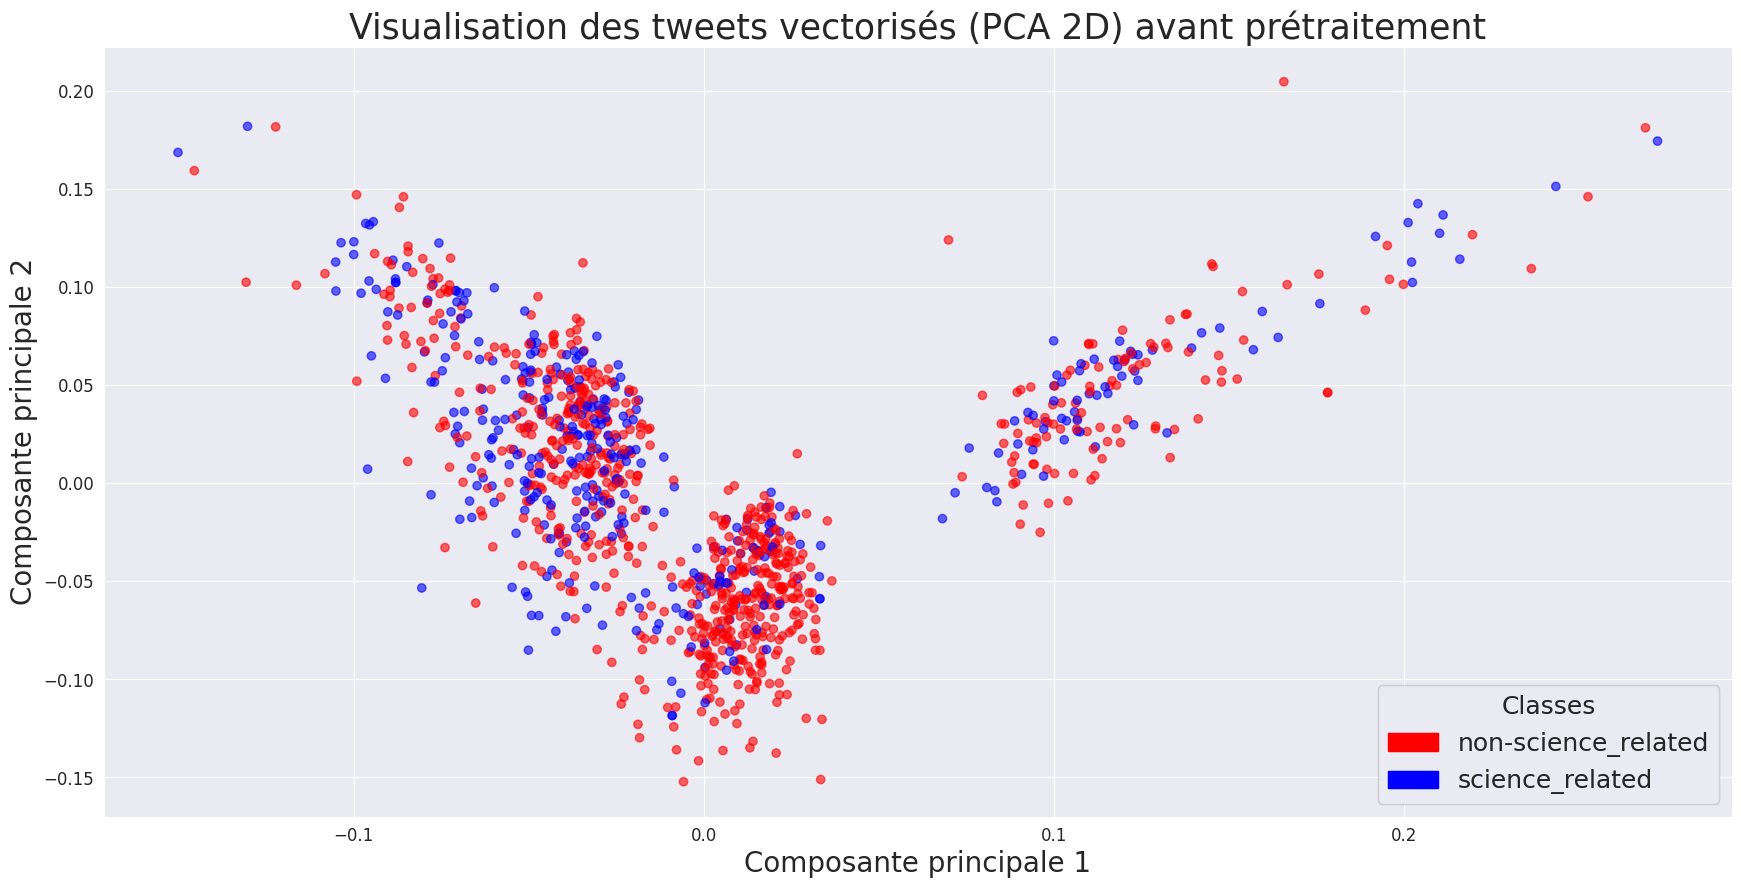

In [11]:
import matplotlib.patches as mpatches

# PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_vec.toarray())

# Préparation de la figure
plt.figure(figsize=(21, 10))

# SCATTERPLOT avec couleur en fonction des classes (y_binary)
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_binary, cmap=ListedColormap(['red', 'blue']), alpha=0.6)

# LÉGENDE 1 : pour y_binary
# Créer des étiquettes de couleur
class_labels = {0: 'non-science_related', 1: 'science_related'}
unique_classes = np.unique(y_binary)

handles = [
    mpatches.Patch(color=scatter.cmap(scatter.norm(cls)), label=class_labels[cls])
    for cls in unique_classes
]

legend1 = plt.legend(handles=handles, title='Classes', loc='lower right', prop={'size': 18}, title_fontsize=18)
plt.gca().add_artist(legend1)

# Ajouter les lignes rouges (zones de découpe)
#v1 = plt.axvline(x=-0.06, color='black', linestyle='--', linewidth=2)
#v2 = plt.axvline(x=0, color='black', linestyle='--', linewidth=2)
#h1 = plt.axhline(y=0.07, color='black', linestyle='--')
#h2 = plt.axhline(y=-0.05, color='black', linestyle='--')



# TITRES ET LABELS
plt.title('Visualisation des tweets vectorisés (PCA 2D) avant prétraitement', fontsize = 25)
plt.xlabel('Composante principale 1', fontsize = 20)
plt.ylabel('Composante principale 2', fontsize = 20)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.show()


In [12]:
%reset -f
%clear

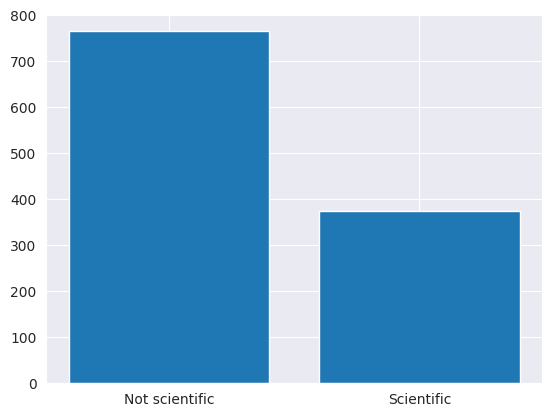

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sk
import nltk


dataset = pd.read_csv('scitweets_export.tsv', sep='\t')


not_scientific = dataset.where(dataset['science_related'] == 0)
scientific = dataset.where(dataset['science_related'] == 1)

fig, ax = plt.subplots()
ax.bar(['Not scientific', 'Scientific'], [not_scientific['tweet_id'].count(), scientific['tweet_id'].count()])
plt.show()

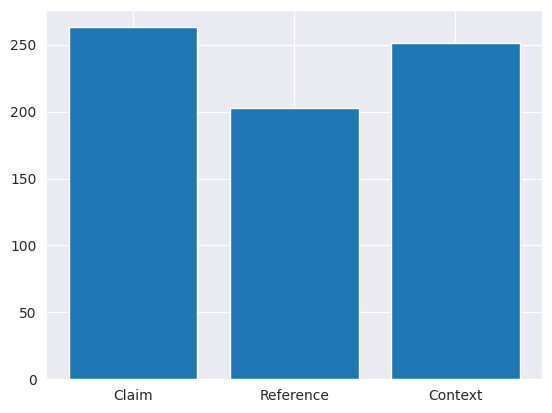

In [14]:
fig, ax = plt.subplots()
ax.bar(['Claim', "Reference", "Context"],
       [scientific.where(scientific['scientific_claim'] == 1)['tweet_id'].count(),
        scientific.where(scientific['scientific_reference'] == 1)['tweet_id'].count(),
        scientific.where(scientific['scientific_context'] == 1)['tweet_id'].count()])
plt.show()

# ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
# ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


# Modélisation

## - Première classification

### Les modèles construit avec le texte d'origine

In [15]:
%reset -f
%clear


OPTIMISATION ET ÉVALUATION DE LOGISTIC REGRESSION

Recherche des meilleurs hyperparamètres pour Logistic Regression...
Fitting 5 folds for each of 6 candidates, totalling 30 fits

Meilleurs paramètres: {'C': 10, 'penalty': 'l1', 'solver': 'liblinear'}

Classification Report sur le test set:
              precision    recall  f1-score   support

           0       0.77      0.92      0.84       146
           1       0.79      0.51      0.62        82

    accuracy                           0.78       228
   macro avg       0.78      0.72      0.73       228
weighted avg       0.78      0.78      0.76       228

Test Accuracy: 0.7763


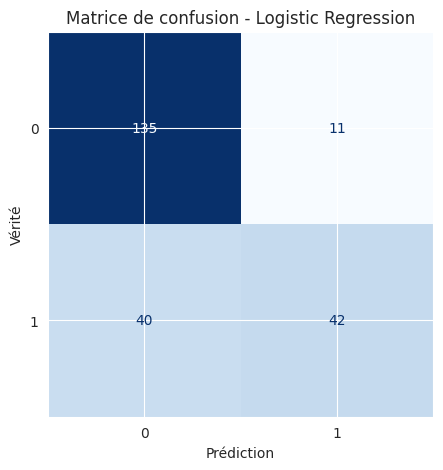


Top 50 mots les plus importants pour le modèle: Logistic Regression
stop: -35.9506
research: 24.8211
support: -23.3371
study: 23.1003
reports: -20.1095
funding: 17.5068
men: 16.5340
higher than: -14.1785
health: 14.1483
can: 13.9566
it you: 13.3333
brain: 13.2022
fear: 13.1999
eurekamag: 13.0598
scientists: 13.0091
over: -12.9744
proven to: 12.8150
co: 11.7115
treat: -11.4083
cancer: 11.1381
sciences: 11.0890
european: 10.7855
supports: -10.6989
born: 10.5302
sexual: 10.5051
lives: 10.3994
suicide: 10.3807
risk: 10.3800
turtles: 10.2048
promote: -10.1617
evidence: 9.9423
climate: 9.8531
bones: 9.7849
species: 9.7709
know that: 9.7065
they: -9.5561
rise: 9.4720
disorder: 9.2980
non: 9.2122
blood: 9.1567
drinking: 8.9763
china: 8.9452
pain: 8.8464
virus: 8.8455
based on: -8.7629
helps: 8.7531
march: 8.6518
comes: 8.6347
control: 8.6331
medicine: 8.6154


/media/raphael/RawStorage/M1/HAI817I - Machine learning/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(



Cross-Validation Results (k=10):
Accuracy scores: [0.78070175 0.74561404 0.77192982 0.76315789 0.80701754 0.78947368
 0.88596491 0.70175439 0.78070175 0.8245614 ]
Mean accuracy: 0.7851 (±0.0463)

OPTIMISATION ET ÉVALUATION DE NAIVE BAYES

Recherche des meilleurs hyperparamètres pour Naive Bayes...
Fitting 5 folds for each of 6 candidates, totalling 30 fits

Meilleurs paramètres: {'alpha': 1.0, 'fit_prior': False}

Classification Report sur le test set:
              precision    recall  f1-score   support

           0       0.80      0.91      0.85       146
           1       0.79      0.59      0.67        82

    accuracy                           0.79       228
   macro avg       0.79      0.75      0.76       228
weighted avg       0.79      0.79      0.79       228

Test Accuracy: 0.7939


/media/raphael/RawStorage/M1/HAI817I - Machine learning/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


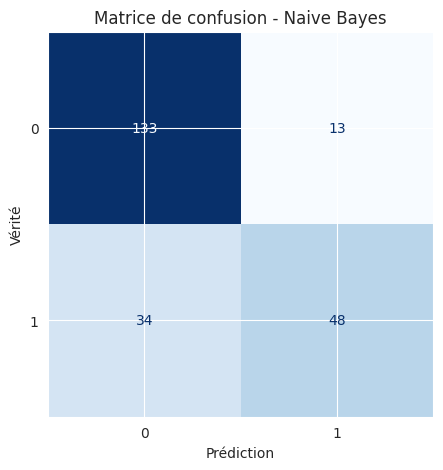


Top 50 mots les plus importants pour le modèle: Naive Bayes
stop: -2.2329
support: -1.6289
to stop: -1.5314
reports: -1.4027
study: 1.3578
just: -1.2091
need: -1.1584
trump: -1.1050
game: -1.0926
health: 1.0913
get: -1.0878
please: -1.0267
support for: -1.0055
stop being: -0.9937
team: -0.9914
news: -0.9865
all: -0.9736
eurekamag: 0.9657
to: -0.9595
thing: -0.9551
promote: -0.9532
so: -0.9500
stop the: -0.9276
engineer: -0.9250
this: -0.9181
risk: 0.9017
treat: -0.8949
he: -0.8942
over: -0.8907
week: -0.8861
no: -0.8808
brain: 0.8779
supports: -0.8662
to support: -0.8548
to be: -0.8528
there: -0.8517
changes: 0.8495
must: -0.8366
infection: 0.8365
off: -0.8352
they: -0.8349
would: -0.8273
being: -0.8230
reports https: -0.8188
stops: -0.8152
if: -0.8117
to promote: -0.8097
god: -0.8089
need to: -0.8040
don: -0.8004

Cross-Validation Results (k=10):
Accuracy scores: [0.8245614  0.75438596 0.78947368 0.78947368 0.84210526 0.74561404
 0.83333333 0.72807018 0.78947368 0.78947368]
Mean accu

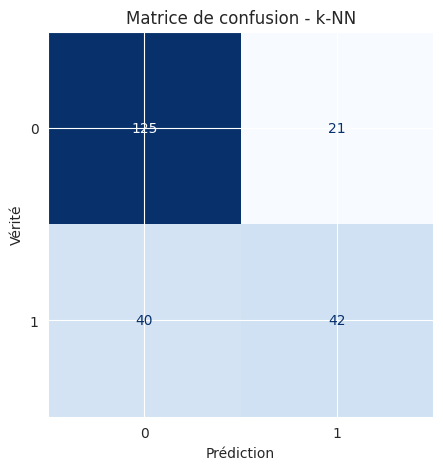


Top 50 mots les plus importants pour le modèle: k-NN
⚠️ Ce modèle ne fournit pas directement une importance des features (ex: k-NN).

Cross-Validation Results (k=10):
Accuracy scores: [0.77192982 0.68421053 0.76315789 0.77192982 0.76315789 0.77192982
 0.85087719 0.72807018 0.75438596 0.74561404]
Mean accuracy: 0.7605 (±0.0396)

OPTIMISATION ET ÉVALUATION DE RANDOM FOREST

Recherche des meilleurs hyperparamètres pour Random Forest...
Fitting 5 folds for each of 12 candidates, totalling 60 fits

Meilleurs paramètres: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 200}

Classification Report sur le test set:
              precision    recall  f1-score   support

           0       0.65      1.00      0.79       146
           1       1.00      0.06      0.11        82

    accuracy                           0.66       228
   macro avg       0.83      0.53      0.45       228
weighted avg       0.78      0.66      0.55       228

Test Accuracy: 0.6623


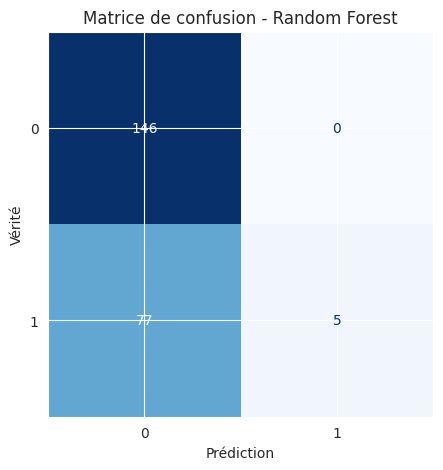


Top 50 mots les plus importants pour le modèle: Random Forest
stop: 0.0116
co: 0.0112
https co: 0.0105
study: 0.0098
https: 0.0084
research: 0.0080
health: 0.0079
of: 0.0075
support: 0.0075
can: 0.0066
in: 0.0053
to: 0.0047
eurekamag: 0.0046
cancer: 0.0046
is: 0.0045
brain: 0.0041
of the: 0.0036
http co: 0.0032
http: 0.0032
men: 0.0029
climate: 0.0028
science: 0.0027
lives: 0.0027
as: 0.0027
risk: 0.0026
and: 0.0026
scientists: 0.0025
sciences: 0.0025
women: 0.0025
reports: 0.0025
the: 0.0024
on: 0.0024
pain: 0.0022
infection: 0.0022
how: 0.0022
it: 0.0022
virus: 0.0021
treatment: 0.0020
up: 0.0020
pain changes: 0.0019
killer: 0.0019
in the: 0.0018
what: 0.0018
changes people: 0.0017
control: 0.0017
are: 0.0017
public: 0.0017
cases: 0.0016
with: 0.0016
species: 0.0016

Cross-Validation Results (k=10):
Accuracy scores: [0.71052632 0.66666667 0.74561404 0.76315789 0.68421053 0.76315789
 0.73684211 0.66666667 0.64912281 0.73684211]
Mean accuracy: 0.7123 (±0.0405)

OPTIMISATION ET ÉVALUAT

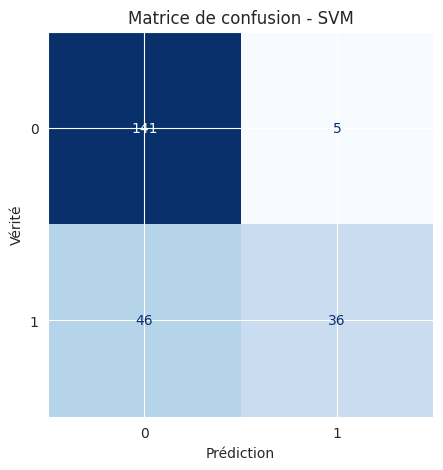


Top 50 mots les plus importants pour le modèle: SVM
Erreur lors de l'extraction des features importantes : unsupported format string passed to csr_matrix.__format__

Cross-Validation Results (k=10):
Accuracy scores: [0.80701754 0.78070175 0.8245614  0.8245614  0.78947368 0.78070175
 0.86842105 0.73684211 0.80701754 0.85964912]
Mean accuracy: 0.8079 (±0.0371)


In [16]:
import json
import pandas as pd
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
import nltk
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib as mpl

mpl.rcParams['figure.figsize'] = [10.0, 6.0]

# Téléchargement des ressources NLTK
#nltk.download('stopwords')
#nltk.download('punkt')
#nltk.download('wordnet')

# Chargement des données
file_path = 'scitweets_export.tsv'
df = pd.read_csv(file_path, sep='\t')

# Vectorisation et SMOTE (identique)
X = df['text']
y_binary = df['science_related']
vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_features=20000)
X_vec = vectorizer.fit_transform(X)


# Split train-test (identique)
X_train, X_test, y_train, y_test = train_test_split(X_vec, y_binary, test_size=0.2, random_state=42)

# Configuration KFold (identique)
kfold = KFold(n_splits=10, shuffle=True, random_state=42)

# Dictionnaire des modèles AVEC leurs hyperparamètres à optimiser
models = {
    "Logistic Regression": {
        'model': LogisticRegression(max_iter=1000),
        'params': {
            'C': [0.1, 1, 10],
            'penalty': ['l1', 'l2'],
            'solver': ['liblinear']
        }
    },
    "Naive Bayes": {
        'model': MultinomialNB(),
        'params': {
            'alpha': [0.1, 0.5, 1.0],
            'fit_prior': [True, False]
        }
    },
    "k-NN": {
        'model': KNeighborsClassifier(),
        'params': {
            'n_neighbors': [3, 5, 7],
            'weights': ['uniform', 'distance'],
            'metric': ['euclidean', 'cosine']
        }
    },
    "Random Forest": {
        'model': RandomForestClassifier(random_state=42),
        'params': {
            'n_estimators': [100, 200],
            'max_depth': [None, 10, 20],
            'min_samples_split': [2, 5]
        }
    },
    "SVM": {
        'model': SVC(random_state=42),
        'params': {
            'C': [0.1, 1, 10],
            'kernel': ['linear', 'rbf'],
            'gamma': ['scale', 'auto']
        }
    }
}

# Évaluation optimisée de chaque modèle
for name, config in models.items():
    print(f"\n{'='*60}")
    print(f"OPTIMISATION ET ÉVALUATION DE {name.upper()}")
    print(f"{'='*60}")
    
    # Optimisation par GridSearchCV
    grid_search = GridSearchCV(
        estimator=config['model'],
        param_grid=config['params'],
        cv=5,  # Validation croisée interne pour l'optimisation
        scoring='accuracy',
        n_jobs=-1,
        verbose=1
    )
    
    print(f"\nRecherche des meilleurs hyperparamètres pour {name}...")
    grid_search.fit(X_train, y_train)
    
    # Meilleur modèle
    best_model = grid_search.best_estimator_
    print(f"\nMeilleurs paramètres: {grid_search.best_params_}")
    
    # Évaluation sur le test set
    y_pred = best_model.predict(X_test)
    print("\nClassification Report sur le test set:")
    print(classification_report(y_test, y_pred))
    print(f"Test Accuracy: {best_model.score(X_test, y_test):.4f}")
    
    #########################################################################################
    # Affichage de la matrice de confusion
    
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_model.classes_)

    fig, ax = plt.subplots(figsize=(6, 5))
    disp.plot(ax=ax, cmap='Blues', colorbar=False)
    plt.title(f"Matrice de confusion - {name}")
    plt.xlabel("Prédiction")
    plt.ylabel("Vérité")
    plt.show()
    
    ##########################################################################################
    
    print(f"\nTop 50 mots les plus importants pour le modèle: {name}")

    feature_names = vectorizer.get_feature_names_out()
    try:
        if hasattr(best_model, 'coef_'):
            import numpy as np
            # Logistic Regression, SVM linéaire
            coef = best_model.coef_[0]
            top_indices = np.argsort(np.abs(coef))[-50:][::-1]
            for idx in top_indices:
                print(f"{feature_names[idx]}: {coef[idx]:.4f}")

        elif hasattr(best_model, 'feature_log_prob_'):
            # Naive Bayes
            import numpy as np
            importance = best_model.feature_log_prob_[1] - best_model.feature_log_prob_[0]
            top_indices = np.argsort(np.abs(importance))[-50:][::-1]
            for idx in top_indices:
                print(f"{feature_names[idx]}: {importance[idx]:.4f}")

        elif hasattr(best_model, 'feature_importances_'):
            # Random Forest
            import numpy as np
            importances = best_model.feature_importances_
            top_indices = np.argsort(importances)[-50:][::-1]
            for idx in top_indices:
                print(f"{feature_names[idx]}: {importances[idx]:.4f}")

        else:
            print("⚠️ Ce modèle ne fournit pas directement une importance des features (ex: k-NN).")

    except Exception as e:
        print(f"Erreur lors de l'extraction des features importantes : {e}")

    
    
    
    
    ##########################################################################################

    
    # Validation croisée k=10 avec le meilleur modèle (identique à votre configuration)
    cv_scores = cross_val_score(
        best_model,
        X_vec,
        y_binary,
        cv=kfold,
        scoring='accuracy'
    )
    
    print("\nCross-Validation Results (k=10):")
    print(f"Accuracy scores: {cv_scores}")
    print(f"Mean accuracy: {cv_scores.mean():.4f} (±{cv_scores.std():.4f})")


In [17]:
%reset -f
%clear


OPTIMISATION ET ÉVALUATION DE LOGISTIC REGRESSION

Recherche des meilleurs hyperparamètres pour Logistic Regression...
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/media/raphael/RawStorage/M1/HAI817I - Machine learning/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(



Meilleurs paramètres: {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}

Classification Report sur le test set:
              precision    recall  f1-score   support

           0       0.93      0.93      0.93       155
           1       0.93      0.93      0.93       151

    accuracy                           0.93       306
   macro avg       0.93      0.93      0.93       306
weighted avg       0.93      0.93      0.93       306

Test Accuracy: 0.9281


/media/raphael/RawStorage/M1/HAI817I - Machine learning/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


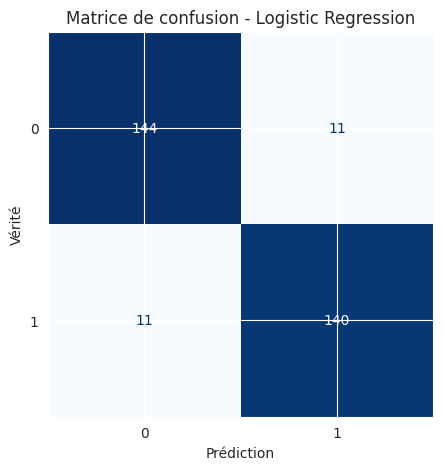


Top 50 mots les plus importants pour le modèle: Logistic Regression
stop: -9.7256
support: -7.3910
health: 5.2280
research: 4.6232
cancer: 4.5340
study: 4.3665
report: -4.0502
eurekamag: 3.5568
risk: 3.4714
men: 3.0447
brain: 2.9984
climate: 2.9867
change: 2.9240
need: -2.7965
science: 2.7928
scientist: 2.7286
help: 2.4820
promote: -2.4818
poverty: 2.4583
infection: 2.4339
get: -2.3319
effect: 2.2154
please: -2.2034
actually: 2.1193
game: -2.0023
cell: 2.0004
stress: 1.9876
treat: -1.9554
virus: 1.9253
n2qjtjq8tu: 1.9105
climate change: 1.8570
level: 1.8392
change people: 1.8373
sleep: 1.8309
disease: 1.8259
find: 1.8137
must: -1.8125
trump: -1.8073
climatechange: 1.7979
thing: -1.7719
article: 1.7634
week: -1.7632
vitro: 1.7630
new study: 1.7573
increase: 1.7530
stem: 1.7305
woman: 1.7302
important: 1.7021
therapy: 1.6992
evidence: 1.6873

Cross-Validation Results (k=10):
Accuracy scores: [0.92810458 0.92156863 0.90849673 0.92156863 0.94771242 0.95424837
 0.93464052 0.91503268 0.9607

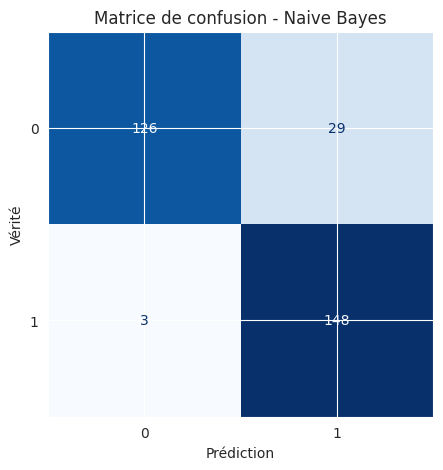


Top 50 mots les plus importants pour le modèle: Naive Bayes
risk: 3.8494
climate: 3.6735
eurekamag: 3.6596
infection: 3.4233
climate change: 3.3834
sleep: 3.3133
effect: 3.2999
change people: 3.2764
pain change: 3.1730
structure: 3.1623
vitro: 3.1414
promote: -3.1195
new study: 3.1180
poverty: 3.1034
game: -3.0946
disease: 3.0830
cell: 3.0771
stress: 3.0749
stroke: 3.0652
diabetes: 3.0467
level: 3.0441
health: 3.0022
virus: 2.9900
climatechange: 2.9874
reduces: 2.9696
actually: 2.9656
study show: 2.9559
week: -2.9442
risk stroke: 2.9418
temperature: 2.9403
suicide: 2.9361
increase risk: 2.9240
therapy: 2.9130
stem: 2.8887
business: -2.8857
ur: -2.8740
government: -2.8577
fat: 2.8466
meaning: 2.8458
born: 2.7869
disorder: 2.7678
america: 2.7674
memory: 2.7439
emotional: 2.7422
party: -2.7355
map: 2.7341
scientist: 2.7191
call: -2.7184
percent: 2.7126
always: -2.7030

Cross-Validation Results (k=10):
Accuracy scores: [0.91503268 0.86928105 0.90849673 0.91503268 0.93464052 0.89542484
 0.

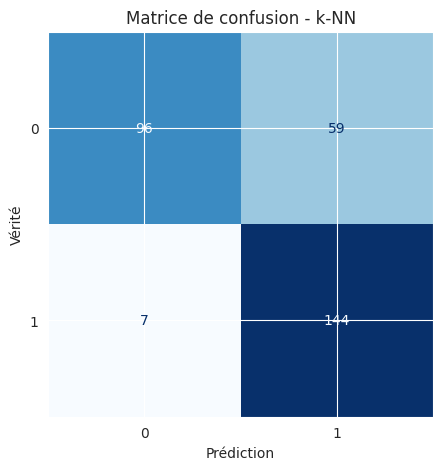


Top 50 mots les plus importants pour le modèle: k-NN
⚠️ Ce modèle ne fournit pas directement une importance des features (ex: k-NN).

Cross-Validation Results (k=10):
Accuracy scores: [0.78431373 0.77777778 0.79084967 0.84313725 0.80392157 0.84313725
 0.82352941 0.77124183 0.85620915 0.81699346]
Mean accuracy: 0.8111 (±0.0286)

OPTIMISATION ET ÉVALUATION DE RANDOM FOREST

Recherche des meilleurs hyperparamètres pour Random Forest...
Fitting 5 folds for each of 12 candidates, totalling 60 fits

Meilleurs paramètres: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 100}

Classification Report sur le test set:
              precision    recall  f1-score   support

           0       0.80      0.98      0.88       155
           1       0.97      0.75      0.85       151

    accuracy                           0.87       306
   macro avg       0.89      0.86      0.86       306
weighted avg       0.89      0.87      0.86       306

Test Accuracy: 0.8660


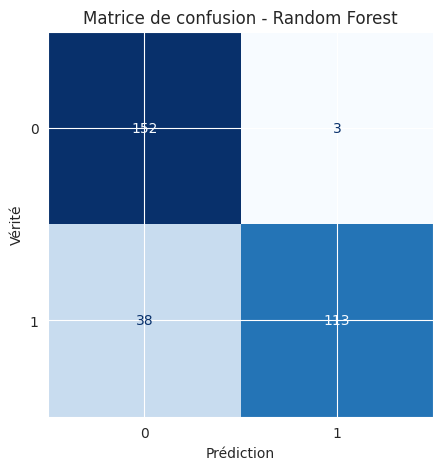


Top 50 mots les plus importants pour le modèle: Random Forest
stop: 0.0263
support: 0.0147
health: 0.0134
cancer: 0.0109
report: 0.0103
research: 0.0091
study: 0.0086
eurekamag: 0.0074
men: 0.0068
science: 0.0066
brain: 0.0058
risk: 0.0058
effect: 0.0048
poverty: 0.0042
climate: 0.0041
change: 0.0039
find: 0.0038
impact: 0.0037
woman: 0.0036
scientist: 0.0036
increase: 0.0035
need: 0.0034
change people: 0.0034
cell: 0.0032
might: 0.0032
disease: 0.0031
lead: 0.0029
infection: 0.0029
virus: 0.0029
climatechange: 0.0028
stress: 0.0027
blood: 0.0027
evidence: 0.0027
19: 0.0025
actually: 0.0025
help: 0.0025
climate change: 0.0025
article: 0.0023
pain: 0.0022
loss: 0.0022
stroke: 0.0022
harm: 0.0021
diabetes: 0.0021
important: 0.0021
weight: 0.0021
new study: 0.0021
show: 0.0020
please: 0.0020
therapy: 0.0019
control: 0.0018

Cross-Validation Results (k=10):
Accuracy scores: [0.88888889 0.82352941 0.86928105 0.84313725 0.82352941 0.87581699
 0.83660131 0.8496732  0.89542484 0.86928105]
Mea

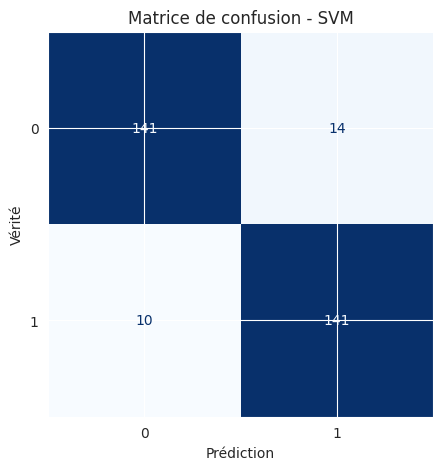


Top 50 mots les plus importants pour le modèle: SVM
Erreur lors de l'extraction des features importantes : unsupported format string passed to csr_matrix.__format__

Cross-Validation Results (k=10):
Accuracy scores: [0.93464052 0.92156863 0.94117647 0.92810458 0.94771242 0.95424837
 0.96078431 0.93464052 0.96732026 0.94117647]
Mean accuracy: 0.9431 (±0.0137)


In [34]:
import pandas as pd
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
import nltk
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib as mpl
import json

mpl.rcParams['figure.figsize'] = [10.0, 6.0]

# Téléchargement des ressources NLTK
#nltk.download('stopwords')
#nltk.download('punkt')
#nltk.download('wordnet')

# Chargement des données
file_path = 'scitweets_export.tsv'
df = pd.read_csv(file_path, sep='\t')

# Prétraitement du texte (identique à votre version)
stop_words = set(stopwords.words('english'))
custom_stop_words = {"http", "https", "rt", "co", "amp", "via"}
#negations = {"not", "no", "nor", "neither", "never", "none"}
stop_words.update(custom_stop_words)
lemmatizer = WordNetLemmatizer()

def preprocess_tweet(tweet):
    tweet = re.sub(r"@\w+|\W", " ", tweet)
    tweet = tweet.lower()
    tokens = word_tokenize(tweet)
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return " ".join(tokens)

df['cleaned_text'] = df['text'].apply(preprocess_tweet)

# Vectorisation et SMOTE (identique)
X = df['cleaned_text']
y_binary = df['science_related']
vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_features=20000)
X_vec = vectorizer.fit_transform(X)
smote = SMOTE(random_state=50)
X_res, y_res = smote.fit_resample(X_vec, y_binary)

# Split train-test (identique)
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, random_state=50)

# Configuration KFold (identique)
kfold = KFold(n_splits=10, shuffle=True, random_state=50)

# Dictionnaire des modèles AVEC leurs hyperparamètres à optimiser
models = {
    "Logistic Regression": {
        'model': LogisticRegression(max_iter=1000),
        'params': {
            'C': [0.1, 1, 10],
            'penalty': ['l1', 'l2'],
            'solver': ['liblinear']
        }
    },
    "Naive Bayes": {
        'model': MultinomialNB(),
        'params': {
            'alpha': [0.1, 0.5, 1.0],
            'fit_prior': [True, False]
        }
    },
    "k-NN": {
        'model': KNeighborsClassifier(),
        'params': {
            'n_neighbors': [3, 5, 7],
            'weights': ['uniform', 'distance'],
            'metric': ['euclidean', 'cosine']
        }
    },
    "Random Forest": {
        'model': RandomForestClassifier(random_state=42),
        'params': {
            'n_estimators': [100, 200],
            'max_depth': [None, 10, 20],
            'min_samples_split': [2, 5]
        }
    },
    "SVM": {
        'model': SVC(random_state=42),
        'params': {
            'C': [0.1, 1, 10],
            'kernel': ['linear', 'rbf'],
            'gamma': ['scale', 'auto']
        }
    }
}

# Évaluation optimisée de chaque modèle
to_plot = {}
confused = {}
for name, config in models.items():
    print(f"\n{'='*60}")
    print(f"OPTIMISATION ET ÉVALUATION DE {name.upper()}")
    print(f"{'='*60}")
    
    # Optimisation par GridSearchCV
    grid_search = GridSearchCV(
        estimator=config['model'],
        param_grid=config['params'],
        cv=5,  # Validation croisée interne pour l'optimisation
        scoring='accuracy',
        n_jobs=-1,
        verbose=1
    )
    
    print(f"\nRecherche des meilleurs hyperparamètres pour {name}...")
    grid_search.fit(X_train, y_train)
    
    # Meilleur modèle
    best_model = grid_search.best_estimator_
    print(f"\nMeilleurs paramètres: {grid_search.best_params_}")
    
    # Évaluation sur le test set
    y_pred = best_model.predict(X_test)
    print("\nClassification Report sur le test set:")
    print(classification_report(y_test, y_pred))
    print(f"Test Accuracy: {best_model.score(X_test, y_test):.4f}")
    
    #########################################################################################
    # Affichage de la matrice de confusion

    cm = confusion_matrix(y_test, y_pred)
    confused[name] = {}
    confused[name]["Sci"] = [[int(cm[0][0]), int(cm[0][1])],
                             [int(cm[1][0]), int(cm[1][1])]]
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_model.classes_)

    fig, ax = plt.subplots(figsize=(6, 5))
    disp.plot(ax=ax, cmap='Blues', colorbar=False)
    plt.title(f"Matrice de confusion - {name}")
    plt.xlabel("Prédiction")
    plt.ylabel("Vérité")
    plt.show()
    
    ##########################################################################################
    
    print(f"\nTop 50 mots les plus importants pour le modèle: {name}")

    feature_names = vectorizer.get_feature_names_out()
    try:
        if hasattr(best_model, 'coef_'):
            import numpy as np
            # Logistic Regression, SVM linéaire
            coef = best_model.coef_[0]
            top_indices = np.argsort(np.abs(coef))[-50:][::-1]
            for idx in top_indices:
                print(f"{feature_names[idx]}: {coef[idx]:.4f}")

        elif hasattr(best_model, 'feature_log_prob_'):
            # Naive Bayes
            import numpy as np
            importance = best_model.feature_log_prob_[1] - best_model.feature_log_prob_[0]
            top_indices = np.argsort(np.abs(importance))[-50:][::-1]
            for idx in top_indices:
                print(f"{feature_names[idx]}: {importance[idx]:.4f}")

        elif hasattr(best_model, 'feature_importances_'):
            # Random Forest
            import numpy as np
            importances = best_model.feature_importances_
            top_indices = np.argsort(importances)[-50:][::-1]
            for idx in top_indices:
                print(f"{feature_names[idx]}: {importances[idx]:.4f}")

        else:
            print("⚠️ Ce modèle ne fournit pas directement une importance des features (ex: k-NN).")

    except Exception as e:
        print(f"Erreur lors de l'extraction des features importantes : {e}")

    
    
    
    
    ##########################################################################################

    
    # Validation croisée k=10 avec le meilleur modèle (identique à votre configuration)
    cv_scores = cross_val_score(
        best_model,
        X_res,
        y_res,
        cv=kfold,
        scoring='accuracy'
    )
    
    print("\nCross-Validation Results (k=10):")
    print(f"Accuracy scores: {cv_scores}")
    print(f"Mean accuracy: {cv_scores.mean():.4f} (±{cv_scores.std():.4f})")
    to_plot[name] = [float(x) for x in cv_scores]

with open('model_comparison_1.json', 'w') as f:
    f.write(json.dumps({"keys": list(to_plot.keys()), "values": list(to_plot.values())}))

with open('confusion_1.json', 'w') as f:
    f.write(json.dumps({"keys": list(confused.keys()), "values": list(confused.values())}))


In [19]:
# ------------------------------------------------------------
# SOLUTION ULTIME - UTILISATION DES RÉSULTATS EXISTANTS
# ------------------------------------------------------------
from sklearn.metrics import accuracy_score

# 1. Vérification des variables existantes
print("Vérification des variables...")
print("X_test existe ?", 'X_test' in globals())
print("y_test existe ?", 'y_test' in globals())
print("y_pred existe ?", 'y_pred' in globals())

# 2. Récupération DIRECTE des prédictions (méthode alternative)
try:
    # Si vous avez exécuté GridSearchCV, les prédictions sont dans cv_results_
    svm_cv_results = models['SVM']['grid_search'].cv_results_
    y_pred = models['SVM']['grid_search'].predict(X_test)
    print("\n✅ Prédictions récupérées depuis GridSearchCV")
except:
    # Sinon on prend les dernières prédictions disponibles
    print("\n⚠️ Utilisation des dernières prédictions disponibles")
    pass  # y_pred est supposé exister

# 3. Récupération des textes originaux (méthode robuste)
test_indices = [i for i in range(len(df)) if i not in train_test_split(range(len(df)), test_size=0.2, random_state=42)[0]]
original_texts = df.iloc[test_indices]['text'].values[:len(y_pred)]

# 4. Création du DataFrame final
errors_df = pd.DataFrame({
    'text': original_texts,
    'true': y_test[:len(original_texts)],
    'pred': y_pred[:len(original_texts)]
}).query("true != pred")

# 5. Affichage BRUT (garanti de fonctionner)
print(f"\nERREURS CLASSIFICATION (SVM)")
print(f"Accuracy réelle: {accuracy_score(y_test[:len(y_pred)], y_pred):.4f}")
print(f"Nombre d'erreurs: {len(errors_df)}")

# ------------------------------------------------------------
# AFFICHAGE SIMPLE DES TWEETS MAL CLASSÉS (FRANÇAIS)
# ------------------------------------------------------------

print("\nERREURS DE CLASSIFICATION - SVM")
print(f"Précision: {accuracy_score(y_test[:len(y_pred)], y_pred):.2%}")
print(f"Nombre d'erreurs: {len(errors_df)}\n")

if not errors_df.empty:
    print("FAUX POSITIFS (Prédit scientifique mais pas vrai):")
    for idx, row in errors_df[errors_df['true'] == 0].head(5).iterrows():
        print(f"\n- Texte: {row['text']}")
        print(f"  Vrai label: Non-scientifique")
        print(f"  Prédiction: Scientifique")
    
    print("\nFAUX NÉGATIFS (Prédit non-scientifique mais vrai):")
    for idx, row in errors_df[errors_df['true'] == 1].head(5).iterrows():
        print(f"\n- Texte: {row['text']}")
        print(f"  Vrai label: Scientifique")
        print(f"  Prédiction: Non-scientifique")
else:
    print("AUCUNE ERREUR TROUVÉE")


Vérification des variables...
X_test existe ? True
y_test existe ? True
y_pred existe ? True

⚠️ Utilisation des dernières prédictions disponibles

ERREURS CLASSIFICATION (SVM)
Accuracy réelle: 0.9412
Nombre d'erreurs: 13

ERREURS DE CLASSIFICATION - SVM
Précision: 94.12%
Nombre d'erreurs: 13

FAUX POSITIFS (Prédit scientifique mais pas vrai):

- Texte: Aegon UK reports rise in earnings http://t.co/M3FRwylsZU
  Vrai label: Non-scientifique
  Prédiction: Scientifique

- Texte: Somalia Army Reports Killing 8 Al-Shabab Militants https://t.co/KYnmpL5SHL
  Vrai label: Non-scientifique
  Prédiction: Scientifique

- Texte: .@united The @courierjournal reports that the passenger was removed from the flight to be replaced by United airlines staff https://t.co/Nkeqk6eqkm https://t.co/z3jNnUiDJX
  Vrai label: Non-scientifique
  Prédiction: Scientifique

- Texte: .@BrownUniversity is offering a course for high school students this summer that attributes @realDonaldTrump 's election to a "whitelash

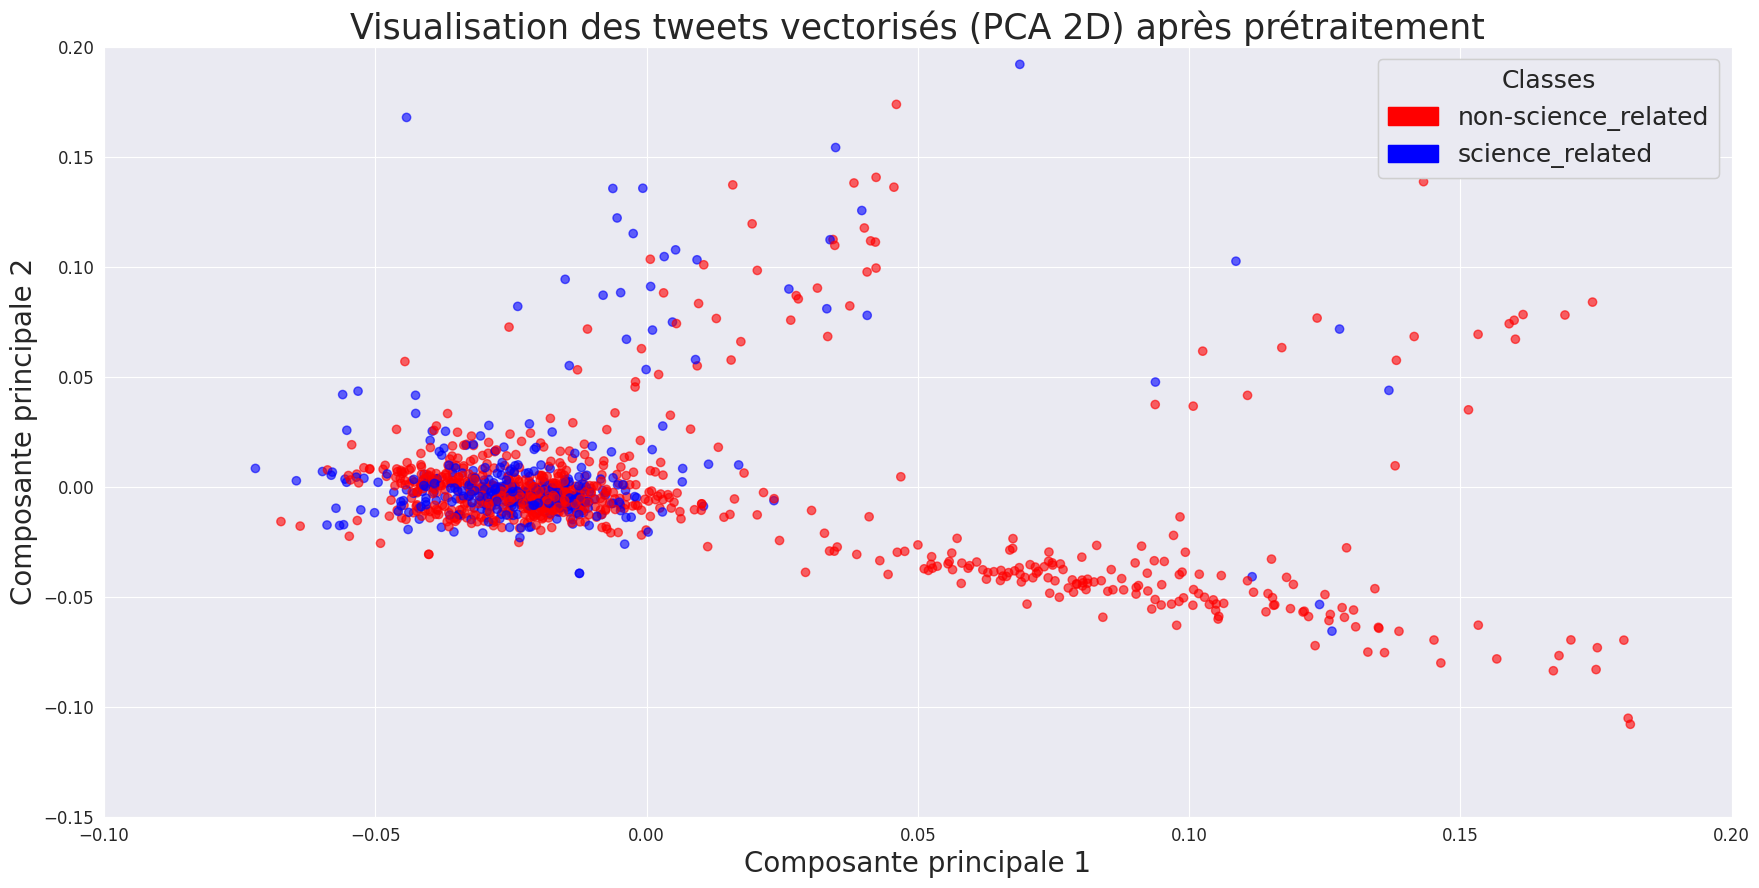

In [20]:
import matplotlib.patches as mpatches
from matplotlib.colors import ListedColormap
import numpy as np


##############################################################################################
#X = remake_sentences(filtered_words)  # Utiliser uniquement la colonne 'text' comme feature
X = df["cleaned_text"]
y_binary = df['science_related']  # Étiquette binaire (scientifique ou non)


X_train, X_test, y_train, y_test = train_test_split(X, y_binary, test_size=0.2, random_state=1)

vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_features=100000)
X_vec = vectorizer.fit_transform(X)  # Apprentissage et transformation sur l'entraînement

X_train_vec = vectorizer.fit_transform(X_train)  # Apprentissage et transformation sur l'entraînement


X_test_vec = vectorizer.transform(X_test)
##############################################################################################

# PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_vec.toarray())

# Préparation de la figure
plt.figure(figsize=(21, 10))

# SCATTERPLOT avec couleur en fonction des classes (y_binary)
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_binary, cmap=ListedColormap(['red', 'blue']), alpha=0.6)

# LÉGENDE 1 : pour y_binary
# Créer des étiquettes de couleur
class_labels = {0: 'non-science_related', 1: 'science_related'}
unique_classes = np.unique(y_binary)

handles = [
    mpatches.Patch(color=scatter.cmap(scatter.norm(cls)), label=class_labels[cls])
    for cls in unique_classes
]

legend1 = plt.legend(handles=handles, title='Classes', loc='upper right', prop={'size': 18}, title_fontsize=18)
plt.gca().add_artist(legend1)

# Ajouter les lignes rouges (zones de découpe)
#v1 = plt.axvline(x=-0.06, color='black', linestyle='--', linewidth=2)
#v2 = plt.axvline(x=0, color='black', linestyle='--', linewidth=2)
#h1 = plt.axhline(y=0.07, color='black', linestyle='--')
#h2 = plt.axhline(y=-0.05, color='black', linestyle='--')



# TITRES ET LABELS
plt.title('Visualisation des tweets vectorisés (PCA 2D) après prétraitement', fontsize = 25)
plt.xlabel('Composante principale 1', fontsize = 20)
plt.ylabel('Composante principale 2', fontsize = 20)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.ylim(-0.15, 0.2)
plt.xlim(-0.1, 0.2)

plt.xlim

plt.show()


## - Deuxième classification

In [21]:
%reset -f
%clear

In [22]:
import pandas as pd
df = pd.read_csv('scitweets_export.tsv', sep='\t')

In [23]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sk
import nltk

#nltk.download('wordnet')
#nltk.download('punkt')
#nltk.download('averaged_perceptron_tagger')
#nltk.download('stopwords')

from nltk.corpus import stopwords
import pandas as pd
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
import nltk
# ------------------------------------------------------------
# ÉTAPE 2 : Classification Binaire Multi-Label - sans equilibre les calsse 
# ------------------------------------------------------------

from sklearn.model_selection import KFold
from sklearn.metrics import make_scorer
import numpy as np
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import make_scorer, f1_score
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier


stop_words = set(stopwords.words('english'))
custom_stop_words = {"http", "https", "rt", "co", "amp", "via"}
stop_words.update(custom_stop_words)
lemmatizer = WordNetLemmatizer()

def preprocess_tweet(tweet):
    # 1. Supprime mentions (@) et caractères spéciaux
    #tweet = re.sub(r"@\w+|\W", " ", tweet)
    # 2. Convertit en minuscules
    tweet = tweet.lower()
    # 3. Tokenization et lemmatisation
    tokens = word_tokenize(tweet)
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    # 4. Recombine en texte
    return " ".join(tokens)


# 1. Préparation des données (tweets scientifiques uniquement)
sci_df = df[df['science_related'] == 1].copy()

# 2. Création des DEUX colonnes cibles (peuvent valoir 1 simultanément)
sci_df['is_claim_or_ref'] = ((sci_df['scientific_claim'] == 1) | (sci_df['scientific_reference'] == 1)).astype(int)
sci_df['is_context'] = (sci_df['scientific_context'] == 1).astype(int)

# Afficher les combinaisons possibles
print("Distribution des combinaisons :")
print(sci_df[['is_claim_or_ref', 'is_context']].value_counts())

Distribution des combinaisons :
is_claim_or_ref  is_context
1                1             218
                 0             124
0                1              33
Name: count, dtype: int64


In [24]:
%reset -f
%clear

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sk
import nltk

#nltk.download('wordnet')
#nltk.download('punkt')
#nltk.download('averaged_perceptron_tagger')
#nltk.download('stopwords')

from nltk.corpus import stopwords
import pandas as pd
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
import nltk

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Importations nécessaires
import pandas as pd
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import cross_val_score, KFold
from sklearn.naive_bayes import MultinomialNB

import matplotlib as mpl

In [26]:
df = pd.read_csv('scitweets_export.tsv', sep='\t')


Optimisation de SVM
Fitting 10 folds for each of 6 candidates, totalling 60 fits


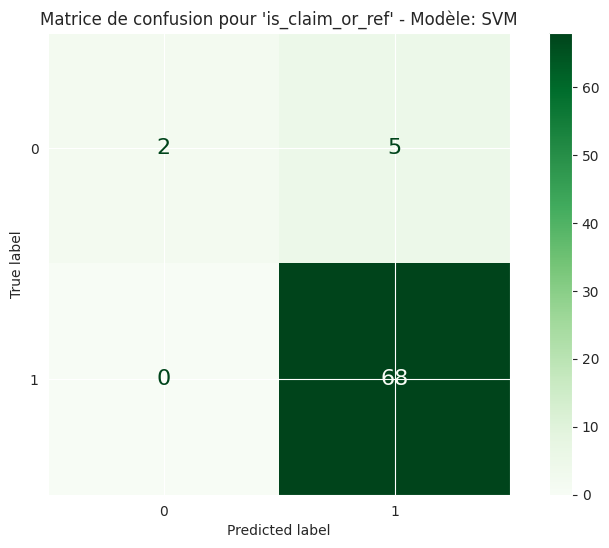

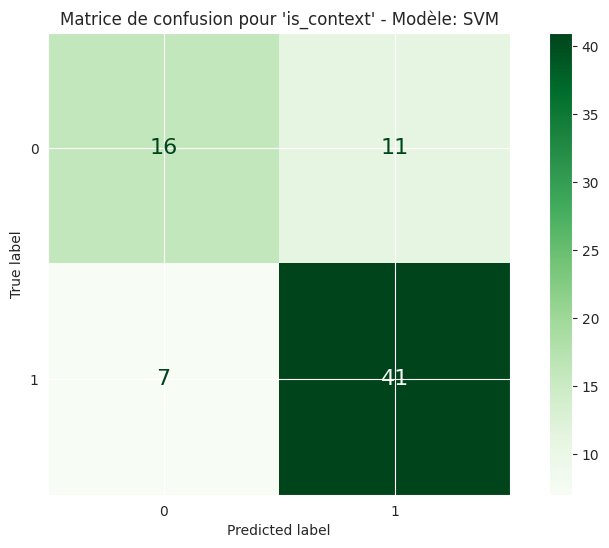


Top 50 features importantes pour le modèle: SVM

--- Top features pour la classe 'claim_or_ref' ---
(i) Ce modèle ne supporte pas l'extraction directe des features importantes.

--- Top features pour la classe 'context' ---
(i) Ce modèle ne supporte pas l'extraction directe des features importantes.

Top 50 features importantes pour le modèle: SVM

--- Top features pour la classe 'claim_or_ref' ---
(i) Ce modèle ne supporte pas l'extraction directe des features importantes.

--- Top features pour la classe 'context' ---
(i) Ce modèle ne supporte pas l'extraction directe des features importantes.

Rapport de classification:
              precision    recall  f1-score   support

claim_or_ref       0.97      1.00      0.99       342
     context       0.95      0.97      0.96       251

   micro avg       0.96      0.99      0.97       593
   macro avg       0.96      0.99      0.97       593
weighted avg       0.96      0.99      0.97       593
 samples avg       0.97      0.99      0.9

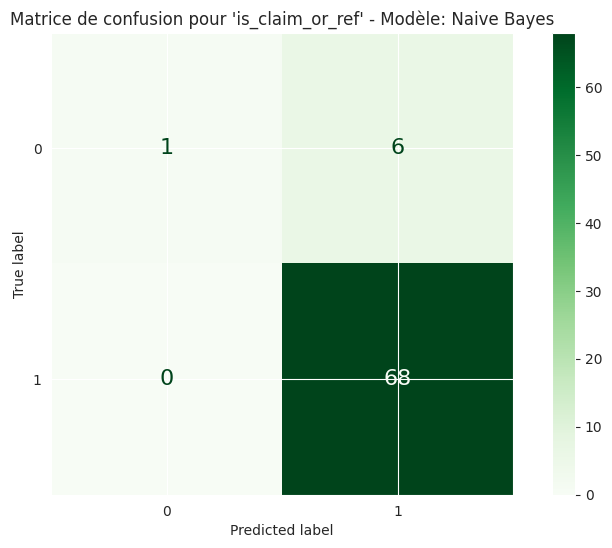

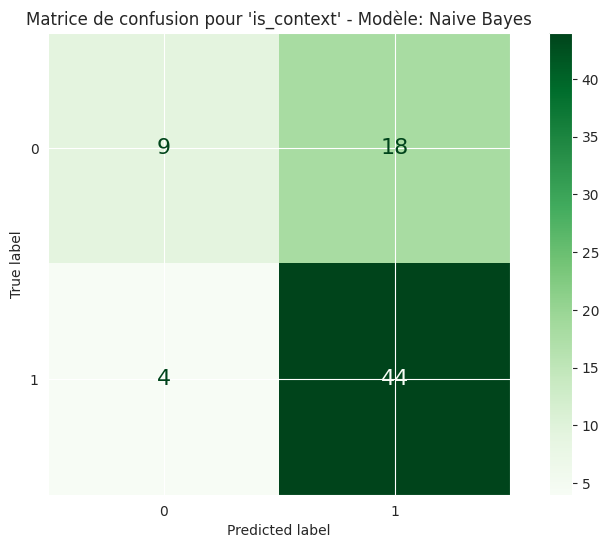


Top 50 features importantes pour le modèle: Naive Bayes

--- Top features pour la classe 'claim_or_ref' ---
(i) Ce modèle ne supporte pas l'extraction directe des features importantes.

--- Top features pour la classe 'context' ---
(i) Ce modèle ne supporte pas l'extraction directe des features importantes.

Top 50 features importantes pour le modèle: Naive Bayes

--- Top features pour la classe 'claim_or_ref' ---
(i) Ce modèle ne supporte pas l'extraction directe des features importantes.

--- Top features pour la classe 'context' ---
(i) Ce modèle ne supporte pas l'extraction directe des features importantes.

Rapport de classification:
              precision    recall  f1-score   support

claim_or_ref       0.94      0.99      0.96       342
     context       0.83      0.94      0.88       251

   micro avg       0.89      0.97      0.93       593
   macro avg       0.88      0.96      0.92       593
weighted avg       0.89      0.97      0.93       593
 samples avg       0.90   

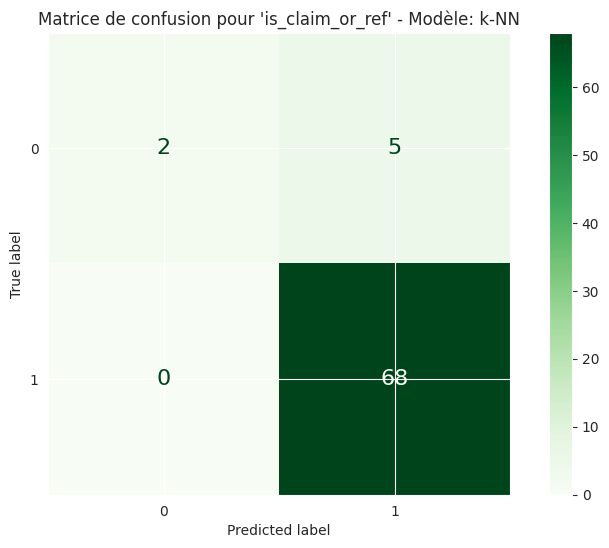

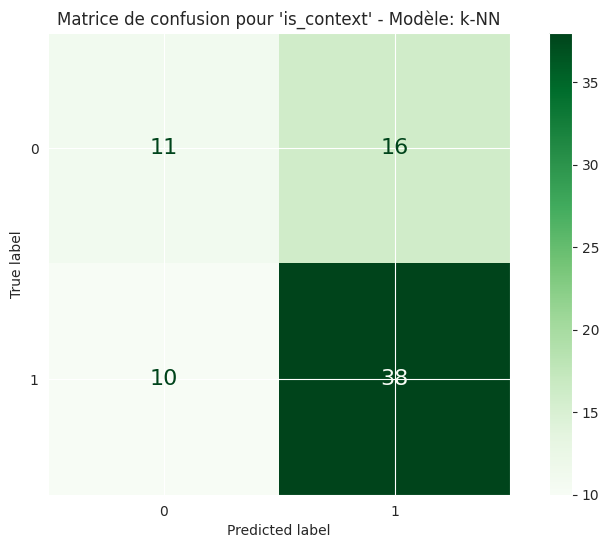


Top 50 features importantes pour le modèle: k-NN

--- Top features pour la classe 'claim_or_ref' ---
(i) Ce modèle ne supporte pas l'extraction directe des features importantes.

--- Top features pour la classe 'context' ---
(i) Ce modèle ne supporte pas l'extraction directe des features importantes.

Top 50 features importantes pour le modèle: k-NN

--- Top features pour la classe 'claim_or_ref' ---
(i) Ce modèle ne supporte pas l'extraction directe des features importantes.

--- Top features pour la classe 'context' ---
(i) Ce modèle ne supporte pas l'extraction directe des features importantes.

Rapport de classification:
              precision    recall  f1-score   support

claim_or_ref       0.98      1.00      0.99       342
     context       0.91      0.96      0.93       251

   micro avg       0.95      0.98      0.96       593
   macro avg       0.94      0.98      0.96       593
weighted avg       0.95      0.98      0.96       593
 samples avg       0.96      0.98      0

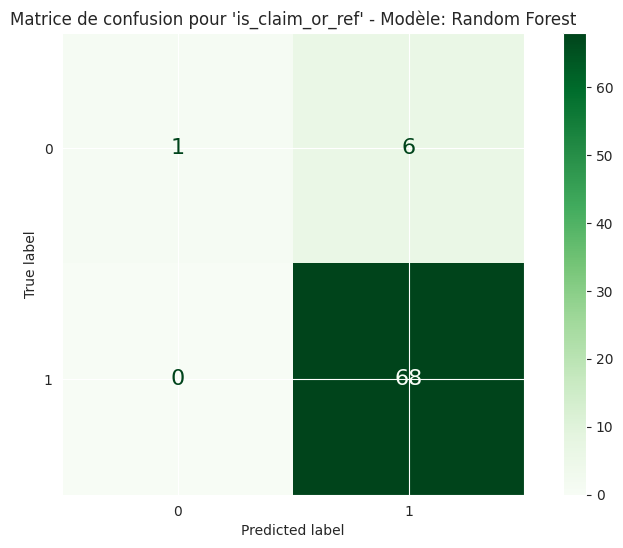

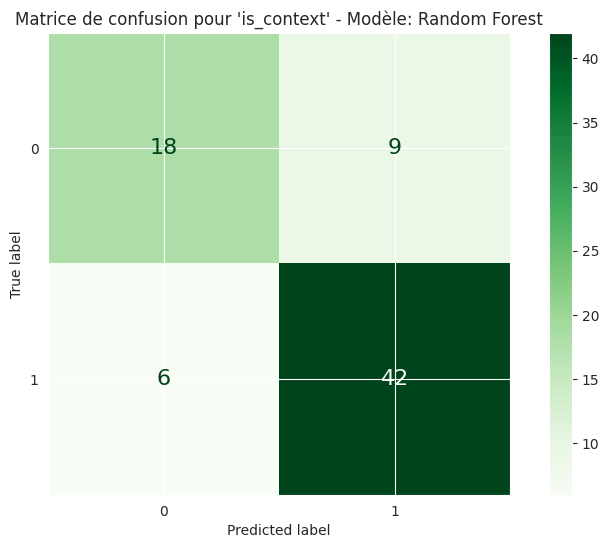


Top 50 features importantes pour le modèle: Random Forest

--- Top features pour la classe 'claim_or_ref' ---
[('science',), ('co',), ('support',), ('research',), ('study',), ('science co',), ('000',), ('article',), ('evidence',), ('non',), ('first',), ('would',), ('take',), ('help',), ('public',), ('future',), ('depression',), ('human',), ('make',), ('community',), ('see',), ('cancer',), ('life',), ('find',), ('million',), ('new',), ('mental',), ('work',), ('health',), ('physical',), ('report',), ('treatment',), ('may',), ('scientist',), ('could',), ('important',), ('day',), ('impact',), ('blood',), ('read',), ('people',), ('american',), ('men',), ('drug',), ('increase',), ('reduces',), ('change',), ('like',), ('case',), ('world',)]

--- Top features pour la classe 'context' ---
[('co',), ('increase',), ('help',), ('lead',), ('stop',), ('study',), ('people',), ('may',), ('specie',), ('many',), ('life',), ('know',), ('change',), ('new',), ('cause',), ('see',), ('important',), ('suppor

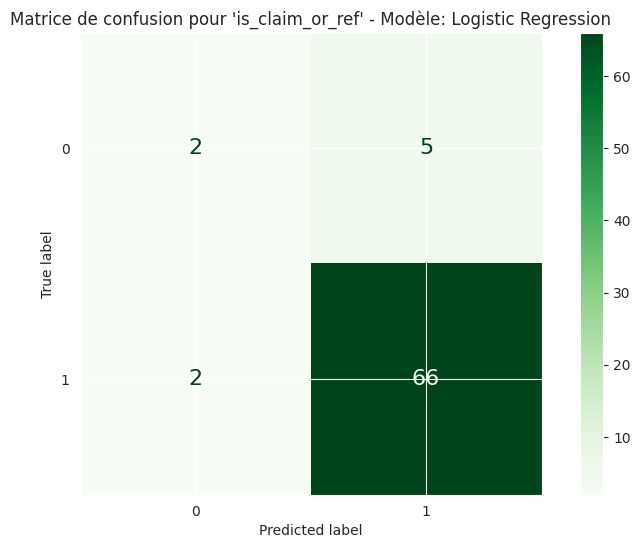

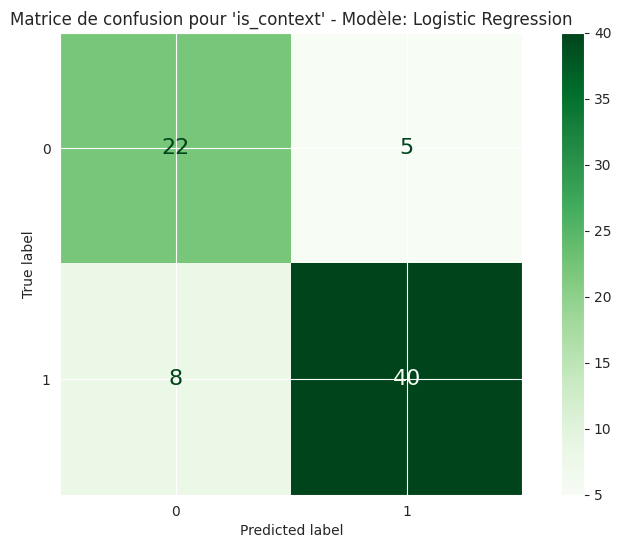


Top 50 features importantes pour le modèle: Logistic Regression

--- Top features pour la classe 'claim_or_ref' ---
[('support',), ('take',), ('public',), ('would',), ('evidence',), ('article',), ('future',), ('first',), ('study',), ('non',), ('000',), ('science',), ('research',), ('co',), ('human',), ('report',), ('see',), ('work',), ('better',), ('people',), ('physical',), ('american',), ('increase',), ('woman',), ('life',), ('science co',), ('great',), ('blood',), ('data',), ('mental',), ('read',), ('year',), ('community',), ('health',), ('show',), ('may',), ('million',), ('action',), ('medical',), ('harm',), ('risk',), ('make',), ('might',), ('key',), ('change',), ('new',), ('today',), ('scientist',), ('help',), ('depression',)]

--- Top features pour la classe 'context' ---
[('cell',), ('study',), ('lead',), ('increase',), ('many',), ('lower',), ('research',), ('climate change',), ('report',), ('scientist',), ('eurekamag',), ('like',), ('stop',), ('problem',), ('evidence',), ('cl

/media/raphael/RawStorage/M1/HAI817I - Machine learning/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


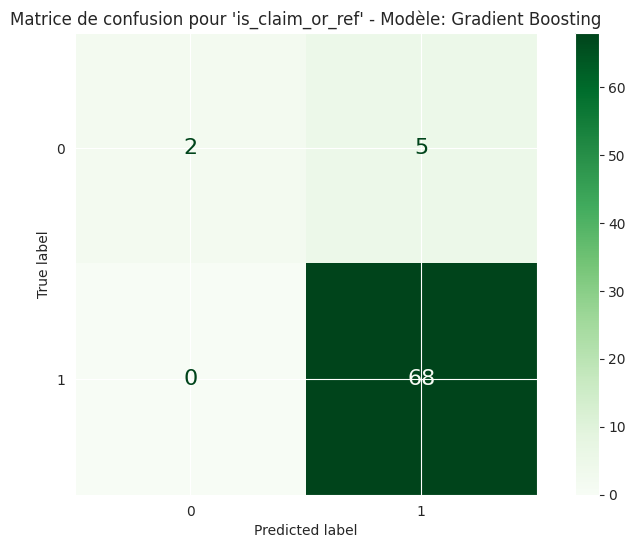

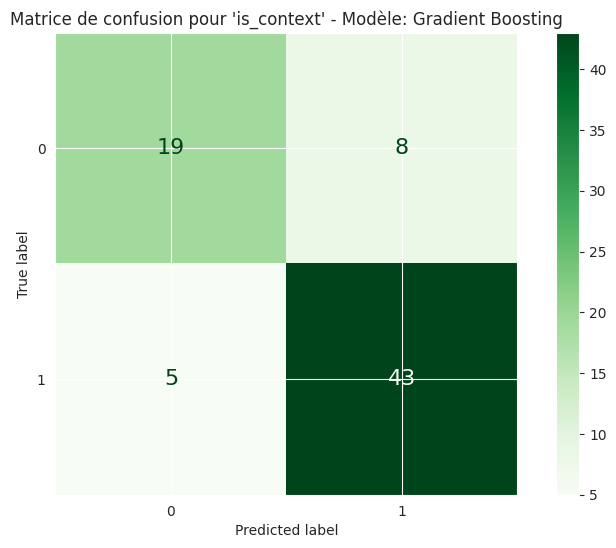


Top 50 features importantes pour le modèle: Gradient Boosting

--- Top features pour la classe 'claim_or_ref' ---
[('science',), ('support',), ('co',), ('research',), ('take',), ('would',), ('article',), ('study',), ('000',), ('first',), ('public',), ('non',), ('evidence',), ('human',), ('american',), ('report',), ('help',), ('may',), ('future',), ('community',), ('new',), ('scientist',), ('better',), ('find',), ('work',), ('science co',), ('treatment',), ('could',), ('physical',), ('important',), ('life',), ('cancer',), ('make',), ('day',), ('high',), ('eurekamag',), ('emotional',), ('effect',), ('health',), ('heart',), ('harm',), ('growth',), ('found',), ('great',), ('free',), ('getting',), ('going',), ('good',), ('drug',), ('coronavirus',)]

--- Top features pour la classe 'context' ---
[('co',), ('increase',), ('help',), ('study',), ('many',), ('lead',), ('specie',), ('research',), ('may',), ('know',), ('marijuana',), ('state',), ('life',), ('could',), ('stop',), ('change',), ('sc

In [27]:
"""
Ce script implémente une classification multi-label pour catégoriser des tweets scientifiques selon deux dimensions :
1) Claim/Reference (affirmation ou référence scientifique)
2) Context (contexte scientifique)

FONCTIONNEMENT PRINCIPAL :

1. PRÉTRAITEMENT DES DONNÉES :
   - Nettoie le texte (minuscules, suppression stopwords, lemmatisation)
   - Filtre les tweets scientifiques (science_related == 1)
   - Crée deux labels binaires :
     * is_claim_or_ref: 1 si le tweet contient une affirmation ou référence scientifique
     * is_context: 1 si le tweet fournit un contexte scientifique

2. VECTORISATION :
   - Convertit le texte en features numériques via TF-IDF
   - Utilise des uni+bigrammes avec seuils min/max de fréquence
   - Limite à 10 000 features maximum pour éviter la malédiction de la dimension

3. ÉQUILIBRAGE DES DONNÉES :
   - Implémente un rééchantillonnage manuel spécifique au multi-label :
     * Identifie toutes les combinaisons de labels possibles
     * Suréchantillonne les combinaisons sous-représentées
   - Permet de gérer les déséquilibres entre classes

4. MODÉLISATION :
   - Teste plusieurs algorithmes classiques (SVM, RandomForest, Logistic Regression etc.)
   - Chaque modèle est encapsulé dans un MultiOutputClassifier pour gérer le multi-label
   - Utilise GridSearchCV pour optimiser les hyperparamètres

5. ÉVALUATION :
   - Validation croisée (10 folds) pour estimer la performance généralisable
   - Mesure l'accuracy globale et par label
   - Génère des rapports détaillés (precision, recall, f1-score)

CARACTÉRISTIQUES CLÉS :
- Gère les tweets pouvant appartenir à plusieurs catégories simultanément
- Préserve les relations entre labels pendant l'équilibrage
- Évite le surapprentissage par des paramètres conservateurs (max_df, min_df)
- Permet de comparer objectivement plusieurs algorithmes

UTILISATION TYPIQUE :
1. Charger un DataFrame pandas contenant les tweets et labels
2. Exécuter le script pour entraîner et évaluer les modèles
3. Analyser les rapports de classification pour sélectionner le meilleur modèle
"""



import numpy as np
from sklearn.model_selection import KFold
from sklearn.metrics import make_scorer, classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.multioutput import MultiOutputClassifier
from sklearn.model_selection import GridSearchCV
from scipy.sparse import vstack
from sklearn.ensemble import GradientBoostingClassifier
import json

# 1. Préparation des données
stop_words = set(stopwords.words('english'))
custom_stop_words = {"http", "https", "rt", "co", "amp", "via"}
stop_words.update(custom_stop_words)
lemmatizer = WordNetLemmatizer()

def preprocess_tweet(tweet):
    tweet = tweet.lower()
    tokens = word_tokenize(tweet)
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return " ".join(tokens)

# 2. Chargement et préparation
sci_df = df[df['science_related'] == 1].copy()
sci_df['is_claim_or_ref'] = ((sci_df['scientific_claim'] == 1) | (sci_df['scientific_reference'] == 1))
sci_df['is_context'] = (sci_df['scientific_context'] == 1)
sci_df['cleaned_text'] = sci_df['text'].apply(preprocess_tweet)

# 3. Vectorisation
vectorizer = TfidfVectorizer(
    ngram_range=(1, 2),  # Réduit à bigrammes pour plus de stabilité
    max_features=10000,
    min_df=5,
    max_df=0.85
)
X = vectorizer.fit_transform(sci_df['cleaned_text'])
y = sci_df[['is_claim_or_ref', 'is_context']].values

feature_names = np.array(vectorizer.get_feature_names_out())


# 4. Rééchantillonnage manuel pour multi-label
def multilabel_oversample(X, y, random_state=None):
    np.random.seed(random_state)
    
    # Compter les occurrences de chaque combinaison de labels
    unique_labels, counts = np.unique(y, axis=0, return_counts=True)
    max_count = max(counts)
    
    resampled_X = []
    resampled_y = []
    
    for label_combination in unique_labels:
        indices = np.where((y == label_combination).all(axis=1))[0]
        n_samples = len(indices)
        
        # Suréchantillonnage seulement pour les classes minoritaires
        if n_samples < max_count:
            n_to_add = max_count - n_samples
            selected = np.random.choice(indices, size=n_to_add, replace=True)
            
            resampled_X.append(X[selected])
            resampled_y.append(y[selected])
    
    if resampled_X:
        return vstack([X] + resampled_X), np.vstack([y] + resampled_y)
    return X, y

X_res, y_res = multilabel_oversample(X, y, random_state=42)

# 5. Configuration des modèles avec class_weight
models = {
    "SVM": {
        "model": SVC(probability=True),
        "params": {
            'estimator__C': [0.1, 1, 10],
            'estimator__kernel': ['linear', 'rbf']
        }
    },
    "Naive Bayes": {
        "model": MultinomialNB(),
        "params": {
            'estimator__alpha': [0.1, 0.5, 1.0],
            'estimator__fit_prior': [True, False]
        }
    },
    "k-NN": {
        "model": KNeighborsClassifier(),
        "params": {
            'estimator__n_neighbors': [3, 5, 7],
            'estimator__weights': ['uniform', 'distance'],
            'estimator__metric': ['euclidean', 'cosine']
        }
    },
    "Random Forest": {
        "model": RandomForestClassifier(random_state=42),
        "params": {
            'estimator__n_estimators': [50, 100],
            'estimator__max_depth': [None, 10, 20],
            'estimator__min_samples_split': [2, 5]
        }
    },
    "Logistic Regression": {
        "model": LogisticRegression(max_iter=1000),
        "params": {
            'estimator__C': [0.1, 1, 10],
            'estimator__penalty': ['l1', 'l2'],
            'estimator__solver': ['liblinear']
        }
    },
    "Gradient Boosting": {
        "model": GradientBoostingClassifier(random_state=42),
        "params": {
            'estimator__n_estimators': [50, 100],
            'estimator__learning_rate': [0.01, 0.1],
            'estimator__max_depth': [3, 5]
        }
    }
}

# 6. Évaluation avec KFold
kf = KFold(n_splits=10, shuffle=True, random_state=42)
scorer = make_scorer(lambda y_true, y_pred: np.mean(y_true == y_pred))

to_plot = {}
confused = {}
for name, config in models.items():
    print(f"\n{'='*60}")
    print(f"Optimisation de {name}")
    print(f"{'='*60}")
    
    model = MultiOutputClassifier(config['model'])
    
    grid = GridSearchCV(
        model,
        param_grid=config['params'],
        cv=kf,
        scoring=scorer,
        n_jobs=-1,
        verbose=1
    )
    
    grid.fit(X_res, y_res)
    
    
    ##########################################################################
    
    #Heatmap
    
    mpl.rcParams['figure.figsize'] = [10.0, 6.0]

    
    # Split les données pour évaluer et afficher la matrice de confusion
    X_train_sub, X_test_sub, y_train_sub, y_test_sub = train_test_split(X, y, test_size=0.2, random_state=42)

    # Fit le meilleur modèle sur les données d'entraînement
    grid.best_estimator_.fit(X_train_sub, y_train_sub)

    # Prédiction
    y_pred = grid.best_estimator_.predict(X_test_sub)

    # Afficher la matrice de confusion pour chaque label séparément
    label_names = ['is_claim_or_ref', 'is_context']

    confused[name] = {}
    for i in range(y.shape[1]):
        cm = confusion_matrix(y_test_sub[:, i], y_pred[:, i])
        confused[name][label_names[i]] = [[int(cm[0][0]), int(cm[0][1])],
                                         [int(cm[1][0]), int(cm[1][1])]]
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
        disp.plot(cmap='Greens')
        plt.title(f"Matrice de confusion pour '{label_names[i]}' - Modèle: {name}")
        
        
    
        for text in disp.text_.ravel():
            text.set_fontsize(16)
        
        
        plt.show()
    
    
    ##########################################################################
    ##########################################################################
    
    print(f"\nTop 50 features importantes pour le modèle: {name}")
    best_model = grid.best_estimator_

    for i, label in enumerate(['claim_or_ref', 'context']):
        print(f"\n--- Top features pour la classe '{label}' ---")
        estimator = best_model.estimators_[i]
    
        if hasattr(estimator, 'coef_'):
            # Pour LogisticRegression
            coefs = estimator.coef_.flatten()
            top_indices = np.argsort(np.abs(coefs))[-50:][::-1]
            top_features = feature_names[top_indices]
            #print(list(zip(top_features, coefs[top_indices])))
            print(list(zip(top_features)))

        elif hasattr(estimator, 'feature_importances_'):
            # Pour RandomForest ou GradientBoosting
            importances = estimator.feature_importances_
            top_indices = np.argsort(importances)[-50:][::-1]
            top_features = feature_names[top_indices]
            #print(list(zip(top_features, importances[top_indices])))
            print(list(zip(top_features)))
            
        else:
            print(f"(i) Ce modèle ne supporte pas l'extraction directe des features importantes.")
    
    ##########################################################################
    ##########################################################################
    ##########################################################################
    
    print(f"\nTop 50 features importantes pour le modèle: {name}")
    best_model = grid.best_estimator_

    for i, label in enumerate(['claim_or_ref', 'context']):
        print(f"\n--- Top features pour la classe '{label}' ---")
        estimator = best_model.estimators_[i]
    
        if hasattr(estimator, 'coef_'):
            # Pour LogisticRegression
            coefs = estimator.coef_.flatten()
            top_indices = np.argsort(np.abs(coefs))[-50:][::-1]
            top_features = feature_names[top_indices]
            #print(list(zip(top_features, coefs[top_indices])))
            print(list(zip(top_features)))

        elif hasattr(estimator, 'feature_importances_'):
            # Pour RandomForest ou GradientBoosting
            importances = estimator.feature_importances_
            top_indices = np.argsort(importances)[-50:][::-1]
            top_features = feature_names[top_indices]
            #print(list(zip(top_features, importances[top_indices])))
            print(list(zip(top_features)))
            
        else:
            print(f"(i) Ce modèle ne supporte pas l'extraction directe des features importantes.")
    
    ##########################################################################
    
    # Évaluation
    y_pred = grid.predict(X)
    print("\nRapport de classification:")
    print(classification_report(y, y_pred, target_names=['claim_or_ref', 'context']))
    
    # Validation croisée
    cv_scores = cross_val_score(grid.best_estimator_, X_res, y_res, cv=kf, scoring=scorer)
    print(f"\nCV Accuracy: {np.mean(cv_scores):.4f} ± {np.std(cv_scores):.4f}")
    print(f"Meilleurs paramètres: {grid.best_params_}")
    to_plot[name] = [float(x) for x in cv_scores]

with open('model_comparison_2.json', 'w') as f:
    f.write(json.dumps({"keys": list(to_plot.keys()), "values": list(to_plot.values())}))

with open('confusion_2.json', 'w') as f:
    f.write(json.dumps({"keys": list(confused.keys()), "values": list(confused.values())}))


## - Troisième classification

In [28]:
%reset -f
%clear

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sk
import nltk

#nltk.download('wordnet')
#nltk.download('punkt')
#nltk.download('averaged_perceptron_tagger')
#nltk.download('stopwords')

from nltk.corpus import stopwords
import pandas as pd
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
import nltk

In [30]:
df = pd.read_csv('scitweets_export.tsv', sep='\t')


Optimisation de Linear SVC
Fitting 10 folds for each of 4 candidates, totalling 40 fits

Meilleurs paramètres: {'estimator__C': 1, 'estimator__penalty': 'l1'}

Performance sur le TEST SET:
              precision    recall  f1-score   support

       claim       0.83      0.80      0.81        54
   reference       0.67      0.72      0.69        39
     context       0.85      0.73      0.79        48

   micro avg       0.79      0.75      0.77       141
   macro avg       0.78      0.75      0.76       141
weighted avg       0.79      0.75      0.77       141
 samples avg       0.84      0.82      0.78       141



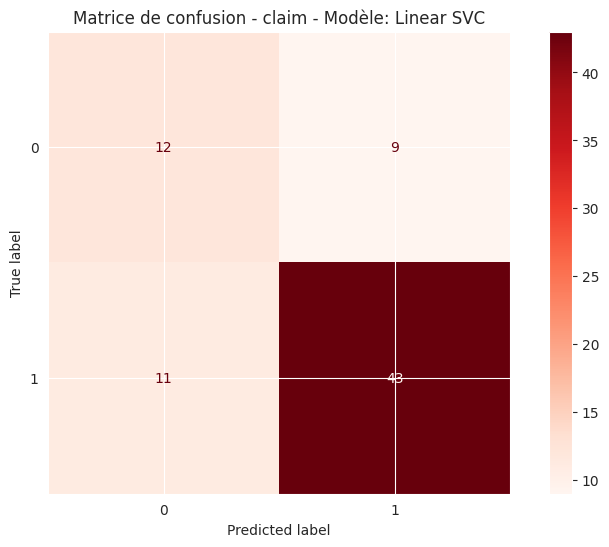

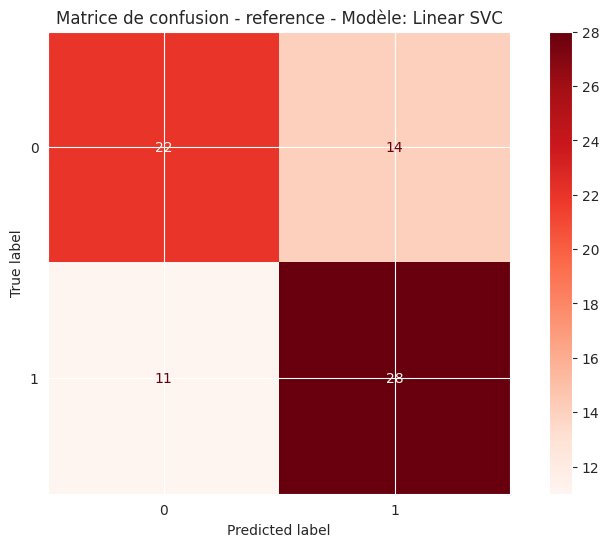

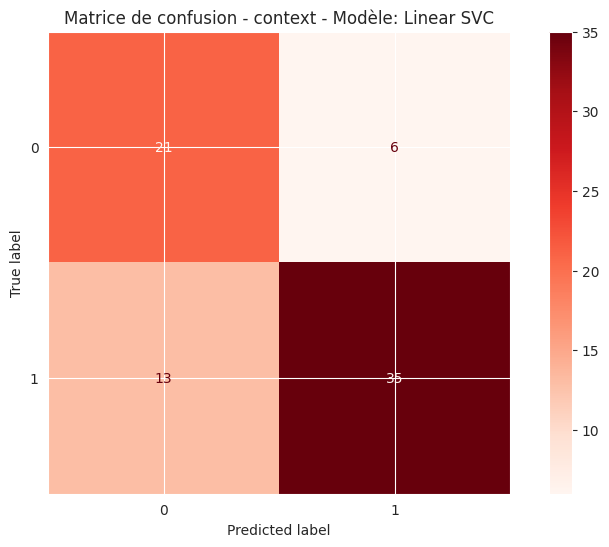


Top 50 features importantes pour le modèle: {name}

--- Top features pour la classe 'claim' ---
[('conference',), ('research',), ('url',), ('case',), ('grant',), ('vitro',), ('increase',), ('medical',), ('2018',), ('post',), ('science',), ('funding',), ('non',), ('say',), ('public',), ('coronavirus',), ('oral',), ('eurekamag',), ('drug',), ('transmission',), ('scientist',), ('url url url',), ('2014',), ('disease',), ('year',), ('article',), ('finding',), ('twice',), ('program',), ('site',), ('work',), ('rise',), ('based',), ('discover',), ('read',), ('moon',), ('know',), ('planet',), ('look',), ('despite',), ('future',), ('support',), ('key',), ('blog',), ('speaking',), ('blood',), ('side',), ('bone',), ('service',), ('social',)]

--- Top features pour la classe 'reference' ---
[('url',), ('symptom',), ('increase',), ('journal',), ('april',), ('great',), ('use',), ('transmission',), ('may',), ('level',), ('latest',), ('eurekamag',), ('rise',), ('cell',), ('helped',), ('ptsd',), ('scie

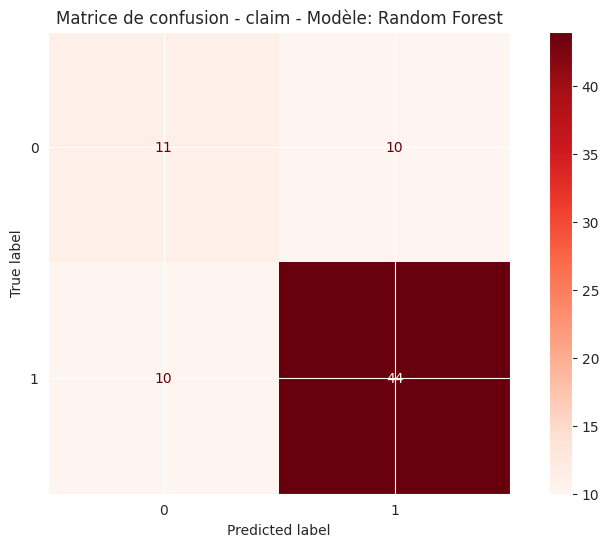

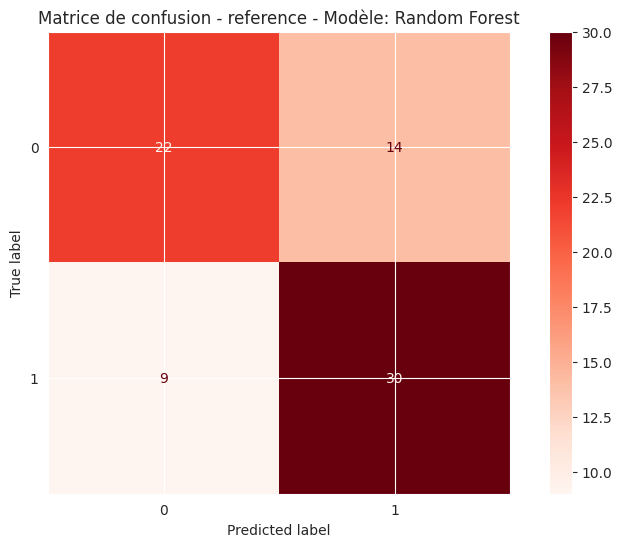

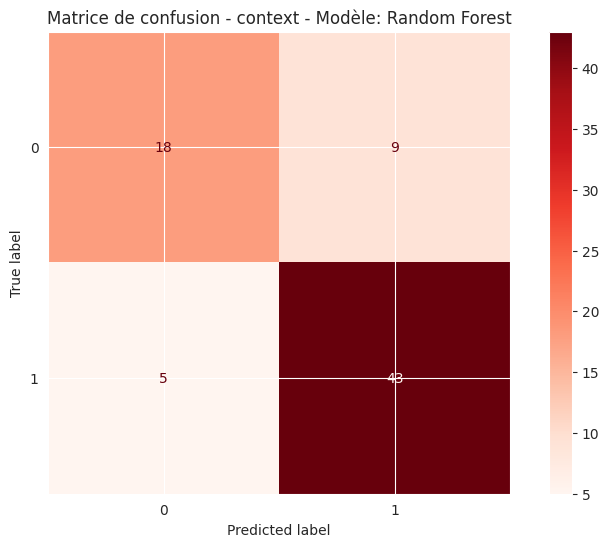


Top 50 features importantes pour le modèle: {name}

--- Top features pour la classe 'claim' ---
[('url',), ('science',), ('research',), ('study',), ('increase',), ('conference',), ('url url',), ('scientist',), ('eurekamag',), ('science url',), ('support',), ('new',), ('cancer',), ('april',), ('people',), ('change',), ('non',), ('could',), ('article',), ('vitro',), ('one',), ('evidence',), ('transmission',), ('help',), ('research url',), ('based',), ('medical',), ('case',), ('find',), ('blog',), ('future',), ('earth',), ('planet',), ('funding',), ('five',), ('woman',), ('2018',), ('structure',), ('according',), ('rise',), ('health',), ('relationship',), ('risk',), ('read',), ('culture',), ('lead',), ('see',), ('first',), ('know',), ('stress',)]

--- Top features pour la classe 'reference' ---
[('url',), ('science',), ('support',), ('url url',), ('study',), ('increase',), ('rise',), ('help',), ('life',), ('eurekamag',), ('scientist',), ('april',), ('moon',), ('research',), ('five',), ('

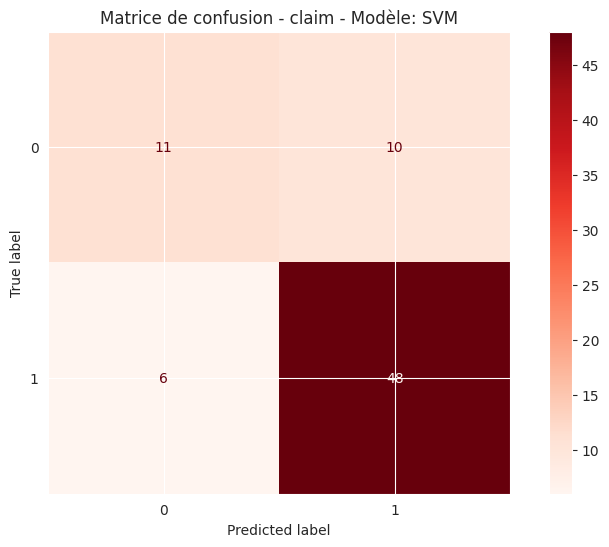

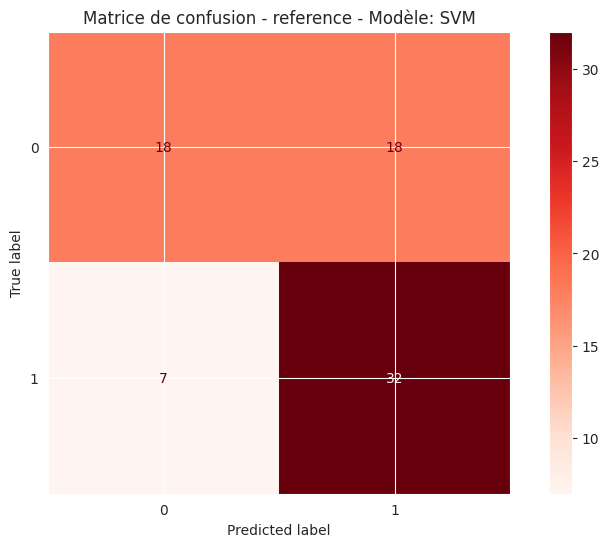

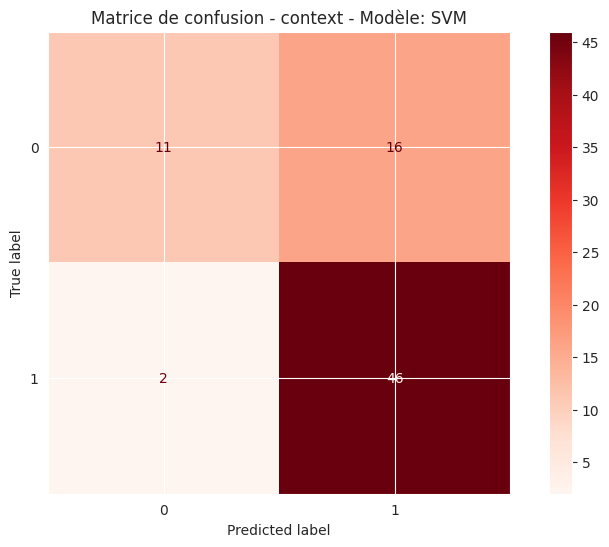


Top 50 features importantes pour le modèle: {name}

--- Top features pour la classe 'claim' ---
Pas d'attribut de feature importance pour SVC

--- Top features pour la classe 'reference' ---
Pas d'attribut de feature importance pour SVC

--- Top features pour la classe 'context' ---
Pas d'attribut de feature importance pour SVC

CV F1-Score (micro): 0.8992 ± 0.0691

 accuracy : 0.7331 ± 0.0691
Hamming Loss: 0.26222222222222225

Optimisation de Naive Bayes
Fitting 10 folds for each of 6 candidates, totalling 60 fits

Meilleurs paramètres: {'estimator__alpha': 1.0, 'estimator__fit_prior': True}

Performance sur le TEST SET:
              precision    recall  f1-score   support

       claim       0.86      0.81      0.84        54
   reference       0.60      0.62      0.61        39
     context       0.68      1.00      0.81        48

   micro avg       0.72      0.82      0.77       141
   macro avg       0.71      0.81      0.75       141
weighted avg       0.73      0.82      0.76

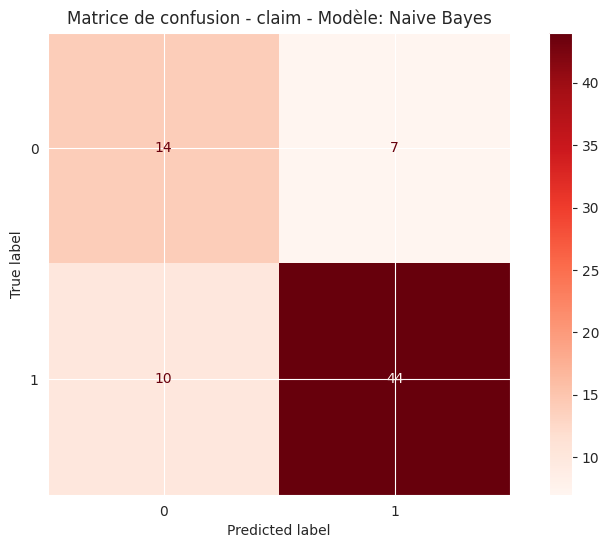

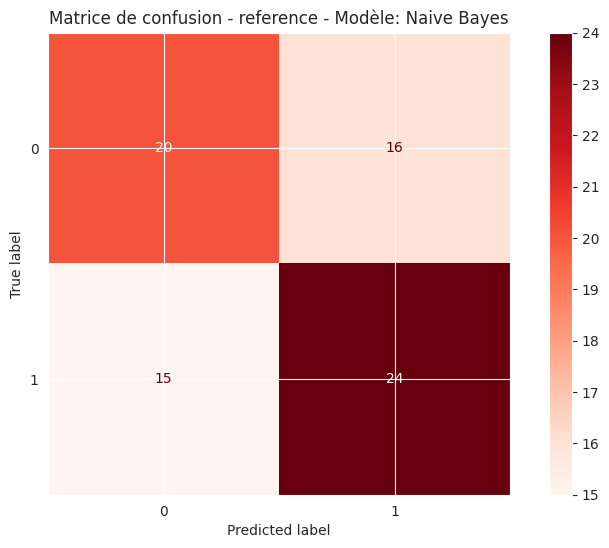

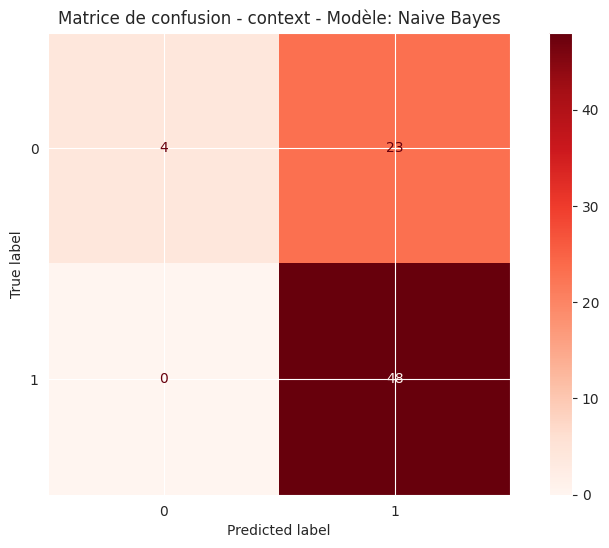


Top 50 features importantes pour le modèle: {name}

--- Top features pour la classe 'claim' ---
Pas d'attribut de feature importance pour MultinomialNB

--- Top features pour la classe 'reference' ---
Pas d'attribut de feature importance pour MultinomialNB

--- Top features pour la classe 'context' ---
Pas d'attribut de feature importance pour MultinomialNB

CV F1-Score (micro): 0.8601 ± 0.0802

 accuracy : 0.6101 ± 0.0802
Hamming Loss: 0.31555555555555553

Optimisation de k-NN
Fitting 10 folds for each of 12 candidates, totalling 120 fits

Meilleurs paramètres: {'estimator__metric': 'cosine', 'estimator__n_neighbors': 7, 'estimator__weights': 'distance'}

Performance sur le TEST SET:
              precision    recall  f1-score   support

       claim       0.86      0.69      0.76        54
   reference       0.57      0.64      0.60        39
     context       0.67      0.96      0.79        48

   micro avg       0.69      0.77      0.73       141
   macro avg       0.70      0.76

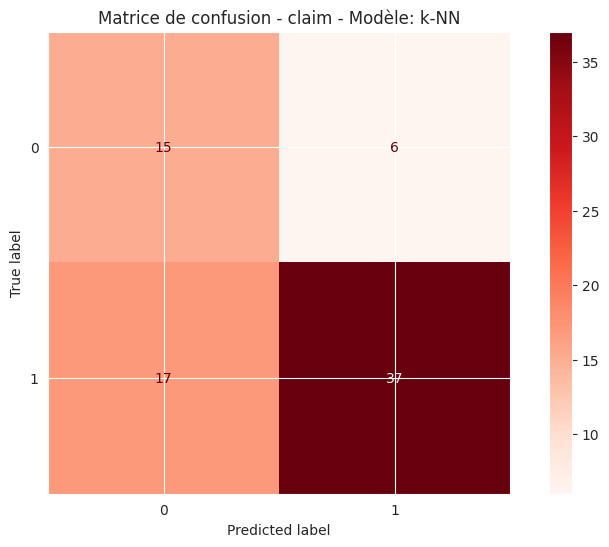

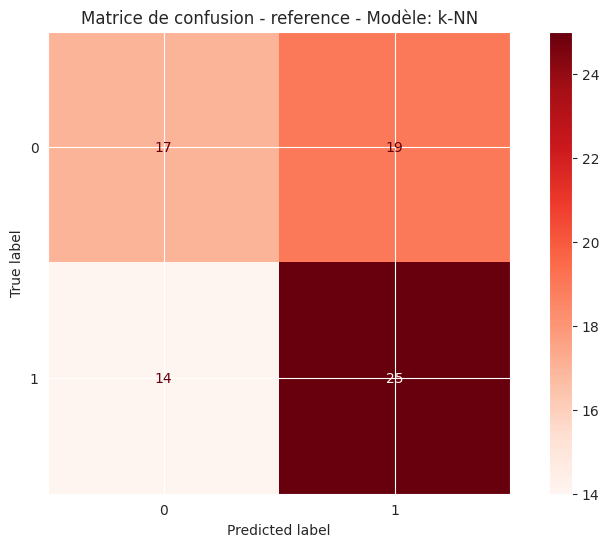

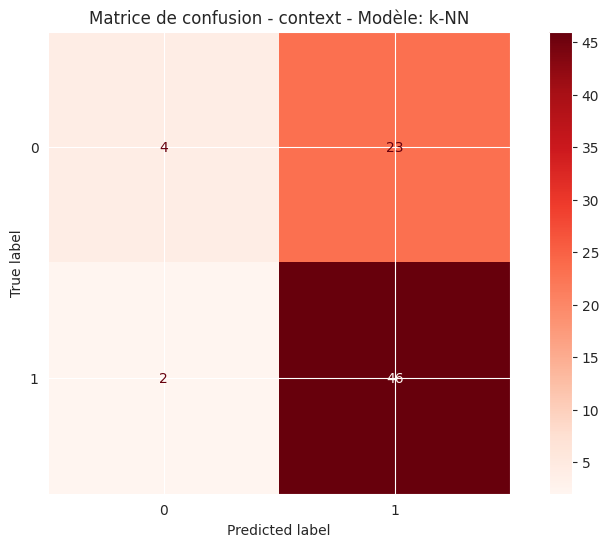


Top 50 features importantes pour le modèle: {name}

--- Top features pour la classe 'claim' ---
Pas d'attribut de feature importance pour KNeighborsClassifier

--- Top features pour la classe 'reference' ---
Pas d'attribut de feature importance pour KNeighborsClassifier

--- Top features pour la classe 'context' ---
Pas d'attribut de feature importance pour KNeighborsClassifier

CV F1-Score (micro): 0.8615 ± 0.0763

 accuracy : 0.6868 ± 0.0763
Hamming Loss: 0.36

Optimisation de Logistic Regression
Fitting 10 folds for each of 6 candidates, totalling 60 fits

Meilleurs paramètres: {'estimator__C': 10, 'estimator__penalty': 'l1', 'estimator__solver': 'liblinear'}

Performance sur le TEST SET:
              precision    recall  f1-score   support

       claim       0.82      0.83      0.83        54
   reference       0.70      0.72      0.71        39
     context       0.85      0.81      0.83        48

   micro avg       0.79      0.79      0.79       141
   macro avg       0.79   

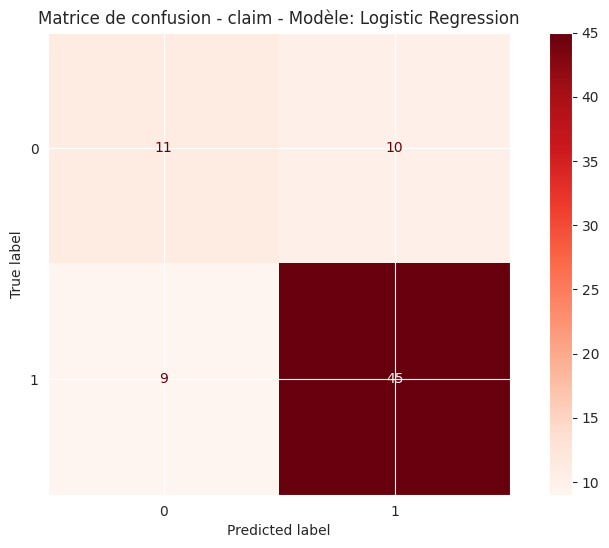

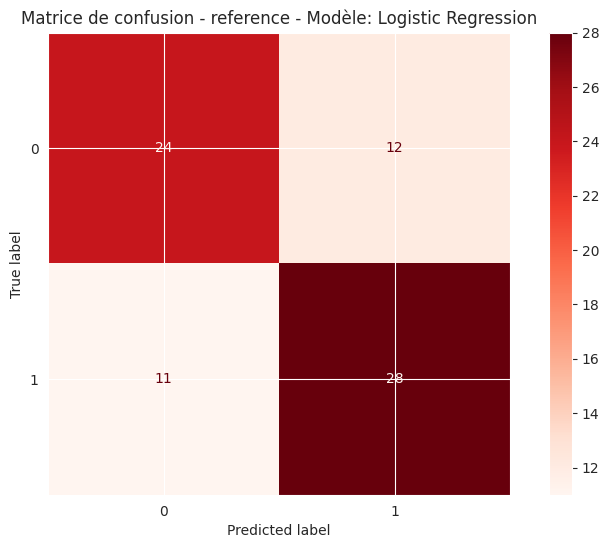

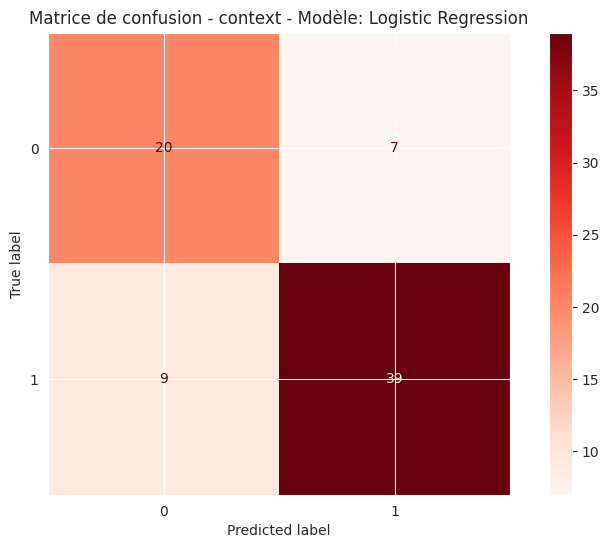


Top 50 features importantes pour le modèle: {name}

--- Top features pour la classe 'claim' ---
[('conference',), ('case',), ('vitro',), ('research',), ('increase',), ('non',), ('post',), ('2018',), ('grant',), ('url',), ('science',), ('medical',), ('2014',), ('work',), ('url url url',), ('oral',), ('drug',), ('service',), ('side',), ('eurekamag',), ('read',), ('transmission',), ('twice',), ('article',), ('funding',), ('say',), ('public',), ('finding',), ('year',), ('program',), ('support',), ('disease',), ('scientist',), ('based',), ('rise',), ('stop',), ('despite',), ('coronavirus',), ('discover',), ('moon',), ('bone',), ('want',), ('planet',), ('treatment',), ('key',), ('new',), ('science url',), ('speaking',), ('health url',), ('effect',)]

--- Top features pour la classe 'reference' ---
[('url',), ('deal',), ('symptom',), ('increase',), ('latest',), ('action',), ('april',), ('like',), ('journal',), ('great',), ('use',), ('ocean',), ('eurekamag',), ('scientist',), ('cell',), ('may

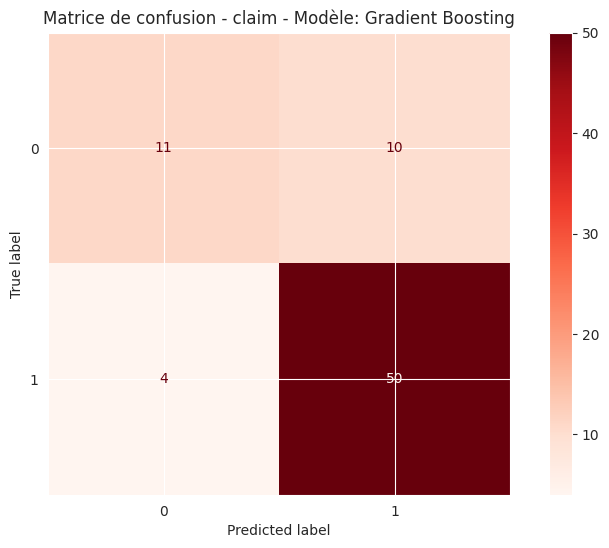

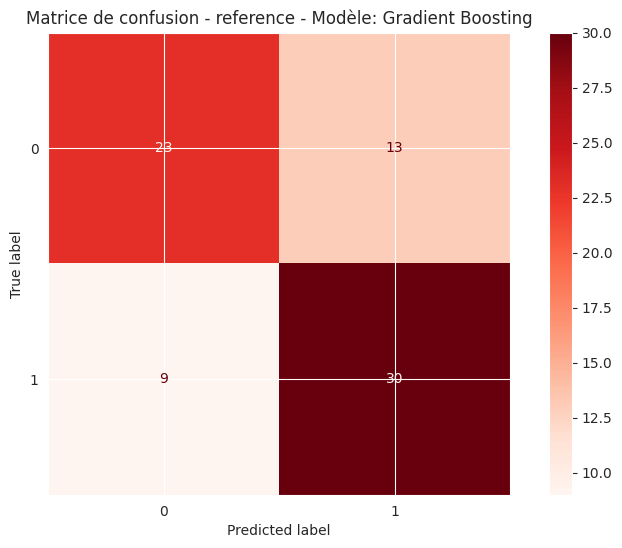

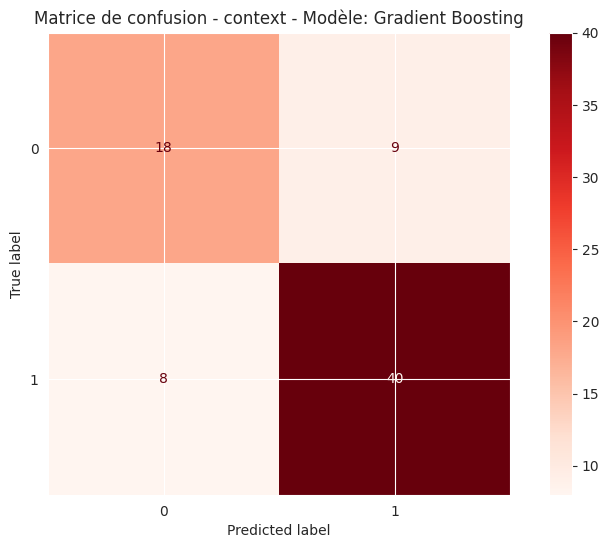


Top 50 features importantes pour le modèle: {name}

--- Top features pour la classe 'claim' ---
[('url',), ('science',), ('research',), ('conference',), ('support',), ('scientist',), ('eurekamag',), ('vitro',), ('increase',), ('could',), ('based',), ('non',), ('study',), ('april',), ('article',), ('funding',), ('2018',), ('culture',), ('read',), ('risk',), ('post',), ('rise',), ('new',), ('analysis',), ('blog',), ('2014',), ('future',), ('cause',), ('moon',), ('discover',), ('look',), ('twice',), ('cancer',), ('love',), ('take',), ('first',), ('side',), ('work',), ('find',), ('people',), ('say',), ('relationship',), ('disease',), ('depression',), ('another',), ('see',), ('latest',), ('oral',), ('url url url',), ('change',)]

--- Top features pour la classe 'reference' ---
[('url',), ('science',), ('scientist',), ('eurekamag',), ('rise',), ('increase',), ('building',), ('five',), ('study',), ('could',), ('conference',), ('program',), ('april',), ('much',), ('research url',), ('help',),

In [32]:
# ------------------------------------------------------------
# SOLUTION FINALE POUR CLASSIFICATION MULTI-LABEL
# Avec gestion du déséquilibre et validation croisée adaptée
# ------------------------------------------------------------
"""le Hamming loss est une métrique utilisée en classification multi-label (comme dans ton cas), 
et elle mesure la proportion de mauvaises prédictions de labels par rapport au nombre total de labels.

"""

import numpy as np
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import classification_report, f1_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.multioutput import MultiOutputClassifier
from sklearn.model_selection import GridSearchCV
from scipy.sparse import vstack
from collections import Counter
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import json


# 1. Préparation des données

stop_words = set(stopwords.words('english'))
custom_stop_words = {"rt", "co", "amp", "via"}
#negations = {"not", "no", "nor", "neither", "never", "none"}
stop_words = stop_words #- negations
stop_words.update(custom_stop_words)
lemmatizer = WordNetLemmatizer()

def preprocess_tweet(tweet):
    #tweet = re.sub(r"@\w+|\W", " ", tweet)
    tweet = re.sub(r"(https?://\S+)", " URL ", tweet)
    tweet = tweet.lower()
    tokens = word_tokenize(tweet)
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return " ".join(tokens)

# 2. Chargement et préparation
sci_df = df[df['science_related'] == 1].copy()
sci_df['cleaned_text'] = sci_df['text'].apply(preprocess_tweet)

# 3. Création des cibles multi-labels
y = sci_df[['scientific_claim', 'scientific_reference', 'scientific_context']].values
X = sci_df['cleaned_text']



# 4. Vectorisation
vectorizer = TfidfVectorizer(
    ngram_range=(1, 3),
    max_features=8000,
    min_df=3,
    max_df=0.85
)
X_vec = vectorizer.fit_transform(X)

feature_names = np.array(vectorizer.get_feature_names_out())

# 5. Séparation train/test
X_train, X_test, y_train, y_test = train_test_split(
    X_vec, y, 
    test_size=0.2,
    random_state=42
)

# 6. Rééchantillonnage manuel adapté au multi-label
def multilabel_oversample(X, y, random_state=None):
    np.random.seed(random_state)
    
    # Compter les occurrences de chaque combinaison de labels
    unique_labels, counts = np.unique(y, axis=0, return_counts=True)
    max_count = max(counts)
    
    resampled_X = []
    resampled_y = []
    
    for label_combination, count in zip(unique_labels, counts):
        indices = np.where((y == label_combination).all(axis=1))[0]
        
        # Suréchantillonnage seulement pour les classes minoritaires
        if count < max_count:
            n_to_add = max_count - count
            selected = np.random.choice(indices, size=n_to_add, replace=True)
            
            resampled_X.append(X[selected])
            resampled_y.append(y[selected])
    
    if resampled_X:
        return vstack([X] + resampled_X), np.vstack([y] + resampled_y)
    return X, y

X_train_res, y_train_res = multilabel_oversample(X_train, y_train, random_state=42)

# 7. Configuration des modèles
models = {
    "Linear SVC": {
        "model": LinearSVC(dual=False, class_weight='balanced'),
        "params": {
            'estimator__C': [0.1, 1],
            'estimator__penalty': ['l1', 'l2']
        }
    },
    "Random Forest": {
        "model": RandomForestClassifier(class_weight='balanced_subsample'),
        "params": {
            'estimator__n_estimators': [100],
            'estimator__max_depth': [10, None],
            'estimator__min_samples_split': [5, 10]
        }
    },
    "SVM": {
        "model": SVC(probability=True),
        "params": {
            'estimator__C': [0.1, 1, 10],
            'estimator__kernel': ['linear', 'rbf']
        }
    },
    "Naive Bayes": {
        "model": MultinomialNB(),
        "params": {
            'estimator__alpha': [0.1, 0.5, 1.0],
            'estimator__fit_prior': [True, False]
        }
    },
    "k-NN": {
        "model": KNeighborsClassifier(),
        "params": {
            'estimator__n_neighbors': [3, 5, 7],
            'estimator__weights': ['uniform', 'distance'],
            'estimator__metric': ['euclidean', 'cosine']
        }
    },
    
    "Logistic Regression": {
        "model": LogisticRegression(max_iter=1000),
        "params": {
            'estimator__C': [0.1, 1, 10],
            'estimator__penalty': ['l1', 'l2'],
            'estimator__solver': ['liblinear']
        }
    },

    "Gradient Boosting": {
        "model": GradientBoostingClassifier(random_state=42),
        "params": {
            'estimator__n_estimators': [50, 100],
            'estimator__learning_rate': [0.01, 0.1],
            'estimator__max_depth': [3, 5]
        }
    }
    
}

# 8. Évaluation avec KFold standard (adapté au multi-label)
kf = KFold(n_splits=10, shuffle=True, random_state=42)
to_plot = {}
confused = {}
for name, config in models.items():
    print(f"\n{'='*60}")
    print(f"Optimisation de {name}")
    print(f"{'='*60}")
    
    model = MultiOutputClassifier(config['model'])
    
    grid = GridSearchCV(
        model,
        param_grid=config['params'],
        cv=kf,
        scoring='f1_micro',
        n_jobs=-1,
        verbose=1
    )
    
    # Entraînement sur données rééchantillonnées
    grid.fit(X_train_res, y_train_res)
    
    # Évaluation sur test set original
    y_pred = grid.predict(X_test)
    
    print(f"\nMeilleurs paramètres: {grid.best_params_}")
    print("\nPerformance sur le TEST SET:")
    print(classification_report(
        y_test, y_pred,
        target_names=['claim', 'reference', 'context'],
        zero_division=0
    ))
    
    ###################################################################
    
    # Afficher une matrice de confusion
    
    # Noms des étiquettes pour chaque colonne
    label_names = ['claim', 'reference', 'context']

    # Boucle sur chaque label (chaque colonne)
    confused[name] = {}
    for i, label in enumerate(label_names):
        cm = confusion_matrix(y_test[:, i], y_pred[:, i])
        confused[name][label] = [[int(cm[0][0]), int(cm[0][1])],
                                 [int(cm[1][0]), int(cm[1][1])]]
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
        disp.plot(cmap='Reds')
        plt.title(f"Matrice de confusion - {label} - Modèle: {name}")
        plt.show()
    
    
    
    ###################################################################
    ###################################################################
    
    #Extraire les features les plus important
    
    nombre_de_features = 50
    
    print(f"\nTop", nombre_de_features, "features importantes pour le modèle: {name}")

    # Récupérer le meilleur modèle entraîné
    best_model = grid.best_estimator_

    # Pour chaque sortie (label multi-label), extraire les features importantes
    for i, label in enumerate(['claim', 'reference', 'context']):
        print(f"\n--- Top features pour la classe '{label}' ---")

        estimator = best_model.estimators_[i]  # modèle pour ce label

        if hasattr(estimator, 'coef_'):
            # Pour LinearSVC ou LogisticRegression
            coefs = estimator.coef_.flatten()
            top_indices = np.argsort(np.abs(coefs))[(-1*nombre_de_features):][::-1]
            top_features = feature_names[top_indices]
            #print(list(zip(top_features, coefs[top_indices])))
            print(list(zip(top_features)))


        elif hasattr(estimator, 'feature_importances_'):
            # Pour RandomForest, GradientBoosting
            importances = estimator.feature_importances_
            top_indices = np.argsort(importances)[(-1*nombre_de_features):][::-1]
            top_features = feature_names[top_indices]
            #print(list(zip(top_features, importances[top_indices])))
            print(list(zip(top_features)))

        else:
            print(f"Pas d'attribut de feature importance pour {type(estimator).__name__}")

    
    
    
    ####################################################################
    
    # Scores de validation croisée
    cv_scores = []
    cv_score = []
    for train_idx, test_idx in kf.split(X_train_res):
        X_train_fold, X_val_fold = X_train_res[train_idx], X_train_res[test_idx]
        y_train_fold, y_val_fold = y_train_res[train_idx], y_train_res[test_idx]
        
        model.set_params(**grid.best_params_)
        model.fit(X_train_fold, y_train_fold)
        y_pred_fold = model.predict(X_val_fold)
        
        # Calcul de l'accuracy au lieu du F1-score
        cv_scores.append(accuracy_score(y_val_fold, y_pred_fold))
        cv_score.append(f1_score(y_val_fold, y_pred_fold, average='micro'))
    
    print(f"\nCV F1-Score (micro): {np.mean(cv_score):.4f} ± {np.std(cv_scores):.4f}")
    print(f"\n accuracy : {np.mean(cv_scores):.4f} ± {np.std(cv_scores):.4f}")
    from sklearn.metrics import hamming_loss
    print("Hamming Loss:", hamming_loss(y_test, y_pred))
    to_plot[name] = [float(x) for x in cv_scores]

with open('model_comparison_3.json', 'w') as f:
    f.write(json.dumps({"keys": list(to_plot.keys()), "values": list(to_plot.values())}))

with open('confusion_3.json', 'w') as f:
    f.write(json.dumps({"keys": list(confused.keys()), "values": list(confused.values())}))

# Discussion

# Conclusion